In [1]:
import numpy as np
from numpy.linalg import norm,inv,pinv,slogdet,matrix_rank
from numpy import array,trace,diag,zeros,ones,full,einsum,sqrt,eye


import itertools
import copy

from time import time
from tqdm import tnrange,tqdm_notebook

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle,Circle,Ellipse
import imageio


import torch


from simulation.sensors_doppler import *
from simulation.sensors_ranging import *
from simulation.sensors_mix import *
from simulation.targets import *
from simulation.utils import observe,q_alpha_d
from simulation.trajectory import *

from estimator.mle_utils import *

from controller.gradient_descent import move,robustmove

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
    "font.monospace": 'Computer Modern Typewriter'
})


import sys
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
torch.set_default_dtype(torch.float64)

In [3]:
#setting constant
target2D_torch = Target2DT()
target2D_np = Target2D()

target3D_torch = Target3DT()
target3D_np = Target3D()

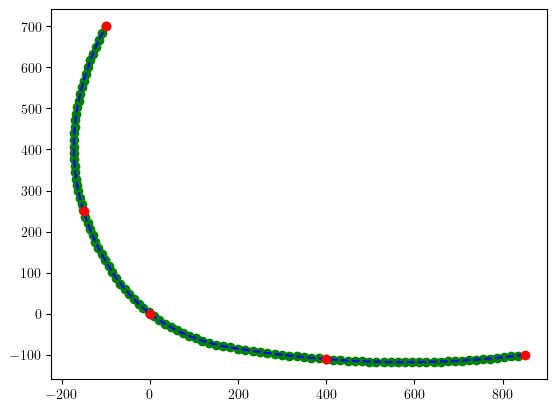

In [4]:
points = np.array([[850,-100],[400,-110],[0,0],[-150.,250],[-100,700]])
xs,ys,a = trajectory_generator_2D(points,101,0)

p = points[0]
vx = 0
vy = 0
for i in range(100):
    px = p[0] + vx + 0.5*a[i,0]
    py = p[1] + vy + 0.5*a[i,1]
    vx = vx + a[i,0]
    vy = vy + a[i,1]
    p =[px,py]
    plt.plot(px,py,'go')

plt.plot(xs,ys,'b--')
plt.plot(points[:,0],points[:,1],'ro')

# Setting I: Range-based 2D sensor
### Stats of observations $y$, for cost function, including
$$\mu(x),C(x),C(x)\prime,\mu(x)\prime,C(x)^{-1}$$

* $x$ is a random variable which denotes target location.  
* $\textbf{xs}$ denotes sensor location. 
* $\textbf{y}$ denotes observation, which depends on both sensors' location and taget location, $\textbf{y} \sim N(\mu(x),C(x))$

* M sensors and each gives one observation, 1-dimensional range observation, N-dimensional space

$$i \in (1,\dots,num\_target)$$
$$j \in (1,\dots,num\_dim)$$
$$k \in (1,\dots,num\_sensor)$$

* 2D transition case:
    * $$\mu(\mathbf{\theta})_i = ||\mathbf{\theta}-s_i||_2$$ 
    * $$[\frac{\partial{\mu(\mathbf{\theta})}}{\partial{\theta}_j}]_{i} = \frac{\theta_j-s_{ij}}{||\mathbf{\theta}-s_i||_2}$$
    * $$ C(\mathbf{\theta})_{ii} = \sigma^2(1+\alpha\mu(\mathbf\theta)_i^2)$$
    * $$[\frac{\partial{C(\mathbf{\theta})}}{\partial{\theta}_j}]_{ii} = 2\alpha\sigma^2 (\theta_{j}-s_{ij})$$
    
    * 4D transition case 1:
    * $$\mu(\mathbf{\theta})_i = ||e^\top\mathbf{\theta}-e^\top s_i||_2$$ 
    * $$[\frac{\partial{\mu(\mathbf{\theta})}}{\partial{\theta}_j}]_{i} = \frac{ee^\top\theta_j-ee^\top s_{ij}}{||e^\top\mathbf{\theta}-e^\top s_i||_2}$$
    * $$ C(\mathbf{\theta})_{ii} = \sigma^2(1+\alpha\mu(\mathbf\theta)_i^2)$$
    * $$[\frac{\partial{C(\mathbf{\theta})}}{\partial{\theta}_j}]_{ii} = 2\alpha\sigma^2 (ee^\top\theta_{j}-ee^\top s_{ij})$$
    
    * 4D transition case 2:
    * $$\mu(\mathbf{\theta})_i = ||e^\top A\mathbf{\theta}-e^\top s_i||_2$$ 
    * $$[\frac{\partial{\mu(\mathbf{\theta})}}{\partial{\theta}_j}]_{i} = \frac{A^\top ee^\top (A\theta_j-s_{ij})}{||e^\top A\mathbf{\theta}-e^\top s_i||_2}$$
    * $$ C(\mathbf{\theta})_{ii} = \sigma^2(1+\alpha\mu(\mathbf\theta)_i^2)$$
    * $$[\frac{\partial{C(\mathbf{\theta})}}{\partial{\theta}_j}]_{ii} = 2\alpha\sigma^2 (A^\top ee^\top(A\theta_{j}-s_{ij}))$$


## Maximum-Likelihood Estimator & Fisher Infomation & Cramer Rao Lower Bound

* MLE

$$ f(X;\theta) = (2\pi)^{-\frac{M}{2}}|Cov(\theta)|^{-\frac{1}{2}}\exp\{-\frac{1}{2}(X-\mu(\theta))^\top Cov(\theta)^{-1}(X-\mu(\theta))\}$$
$$l = \log{f(X;\theta)} = C - \frac{1}{2}log |Cov(\theta)| -\frac{1}{2}(X-\mu(\theta))^\top Cov(\theta)^{-1}(X-\mu(\theta))$$

* Fisher Information, $\textrm{I}(\mathbf{\theta}): (M\times M)$

$${\mathcal {I}}(\theta )=\operatorname {E} \left[\left.\left({\frac {\partial }{\partial \theta }}\log f(X;\theta )\right)^{2}\right|\theta \right]=\int _{\mathbb {R} }\left({\frac {\partial }{\partial \theta }}\log f(x;\theta )\right)^{2}f(x;\theta )\,dx$$

$$[\textrm{I}(\mathbf{\theta})_{ik}] = (\frac{\partial{\mu(\mathbf{\theta})}}{\partial{\theta_i}})^\top C^{-1}(\mathbf{\theta})(\frac{\partial{\mu(\mathbf{\theta})}}{\partial{\theta_k}}) + \frac{1}{2}\textrm{tr}\{C^{-1}(\mathbf{\theta})\frac{\partial{C{(\mathbf{\theta})}}}{\partial{\theta_i}}C^{-1}(\mathbf{\theta})\frac{\partial{C{(\mathbf{\theta})}}}{\partial{\theta_k}}\}$$

* CRLB
$$CRLB = \mathcal{I(\theta)}^{-1}$$

In [5]:
targets = np.array([[3.,1,2,0,-1,5],[2,5,3,0,10,0]]).T
sensors = np.array([[0,0,-2,-1,0,0],[2,3,-2,0,0,0],[10.,-5,-2,0,0,1],[-2.,0,5,0,0,1]]).T

sensor_np = RangingSensor3DFull()
obs = observe(sensor_np.hx(targets,sensors),sensor_np.sx(targets,sensors))
estimate_mle(sensor_np,sensors,obs,np.zeros((6,2)))

(array([[2.79521731, 1.63773267],
        [2.19420626, 5.53625672],
        [1.82707078, 2.59364414],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]]),
 array([[[ 0.42725964, -0.0160812 ,  0.01333314,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.57075396, -0.05044884,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.36799174,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  1.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           1.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  1.        ]],
 
        [[ 0.67452363, -0.13433396,  0.22600534,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.41912469, -0.26273448,  0.        ,
           0.        ,  0.        ],

## System Dynamics

### I: velocity as control
* $\textbf{x}$ denotes state, $\textbf{u}$ denotes control, $\textbf{a}$ denotes adversarial disturbance
 $$\textbf{x}_k = \left(\begin{array}{c}\textbf{x}_k^s\\ 
\textbf{x}_k^t\end{array}\right),\textbf{x}_k^s = [p], \textbf{x}_k^s = \textbf{x}_{k-1}^s + \textbf{u}_k, \textbf{x}_k^t = \textbf{x}_{k-1}^t + \textbf{a}_k$$

### II: acceleration as control
 $$\textbf{x}_k = \left(\begin{array}{c}\textbf{x}_k^s\\ 
\textbf{x}_k^t\end{array}\right),\textbf{x}_k^s = [p,v], \textbf{x}_k^s = \textbf{Ax}_{k-1}^s + \textbf{Bu}_k, \textbf{x}_k^t = \textbf{Ax}_{k-1}^t + \textbf{Ba}_k$$

## Gradient Descent

In [6]:
range_u_s = [-0.3,0.3]
range_u_t = [-0.1,0.1]

sensor_torch = RangingSensor2DT()
sensor_np = RangingSensor2D()

lr_t = 0.01

xs = np.array([[-2.9414, -1.3868,0,0], [-2.5536, -0.6925,0,1],[-1.4836,  0.4326,0.5,0.5]]).T
xt = np.array([[-1.9170, -0.9756, 1,1]]).T

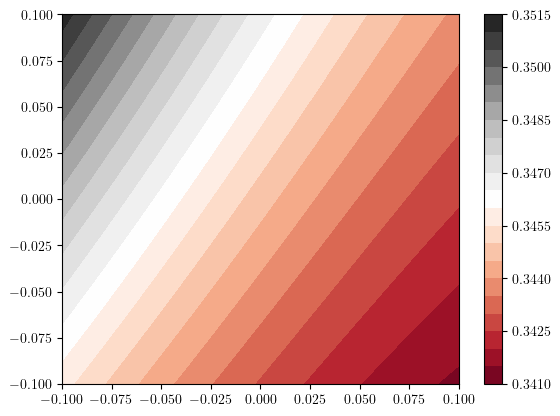

In [7]:
X,Y = np.mgrid[-0.1:0.105:0.005, -0.1:0.105:0.005]
N,M = X.shape
Z = np.zeros((N,M))

for i in range(N):
    for j in range(M):
        u = np.array([[0,0,X[i,j],Y[i,j]]]).T
        xs_ = sensor_np.transition(xs,zeros(xs.shape))
        xt_ = target2D_np.transition(xt,u)
        Z[i,j] = crlb(sensor_np.hx(xt_,xs_),sensor_np.sx(xt_,xs_),sensor_np.H(xt_,xs_)[:,:2],sensor_np.S(xt_,xs_)[:2,:,:])
            
plt.contourf(X, Y, Z, 20, cmap='RdGy')
plt.colorbar()
plt.show()

In [8]:
u_t,losses = move(1,sensor_torch,target2D_torch,torch.tensor(xs),torch.tensor(xt),lr_t,range_u_s,range_u_t,torch.zeros((1,4,4)),torch.ones(1),0,is_target=True)
u_t

tensor([[[-0.0009],
         [-0.0010],
         [-0.0980],
         [ 0.0979]]])

In [9]:
u_s,losses = move(1,sensor_torch,target2D_torch,torch.tensor(xs),torch.tensor(xt),lr_t,range_u_s,range_u_t,torch.zeros((1,4,4)),torch.ones(1),3,is_target=False)
u_s

tensor([[[ 1.5223e-03,  4.6780e-04,  1.3949e-03],
         [-2.2432e-04,  1.3845e-03, -3.3837e-03],
         [ 2.9106e-01,  2.8301e-01, -2.0229e-01],
         [-2.9011e-01,  2.7745e-01, -2.3308e-01]]])

## Gradient Descent Ascent

In [10]:
def sample_actions(a_shape,range_v):
    #upper and lower bound of sample
    range_v_l,range_v_u = range_v
    N,M = a_shape
    sample_size = (3**N)**M
    if not hasattr(range_v_l ,'len'):
        range_v_l = np.full(N,range_v_l)
        
    if not hasattr(range_v_l ,'len'):
        range_v_u = np.full(N,range_v_u)
    
    samples = np.zeros((sample_size,*a_shape))
    
    v = np.zeros((N,3))
    for i in range(N):
        v[i] = [range_v_l[i],0,range_v_u[i]]#lowerbound, zero, upperbound
    
    
    sactions = [[v[j][p[j]] for j in range(N)] for p in itertools.product(*(range(3) for i in range(N)))]
    
    sactions = np.array(sactions)
   
    
    samples = [[sactions[p[j]] for j in range(M)] for p in itertools.product(*(range(9) for i in range(M)))] 
    samples = np.array(samples)
    
    return np.swapaxes(samples,1,2)

def robustmove_samp(x_s,x_t,lr_t,rs,rt,sensor_torch,target_torch):
    s_shape = x_s.shape
    t_shape = x_t.shape
    
    dim = x_t.shape[0]
    min_loss = np.inf
    
    u_s_samples = sample_actions((2,s_shape[1]),rs)
    u_s_samples = torch.tensor(u_s_samples)
    n_samples = u_s_samples.shape[0]
    u_s_samples = torch.cat([torch.zeros((n_samples,2,s_shape[1])),u_s_samples],dim=1)
    
    for i in range(n_samples):
        #sample a action from the space
        u_s = u_s_samples[i]
        
        #perform counter move
        u_t,u_loss = move(1,sensor_torch,target_torch,sensor_torch.transition(x_s,u_s),x_t,lr_t,rs,rt,torch.zeros((1,dim,dim)),torch.ones(1),is_target=True)
        
            
        if u_loss[-1]<min_loss:
            min_loss = u_loss[-1]
            u_s_ = u_s
    
    return u_s_

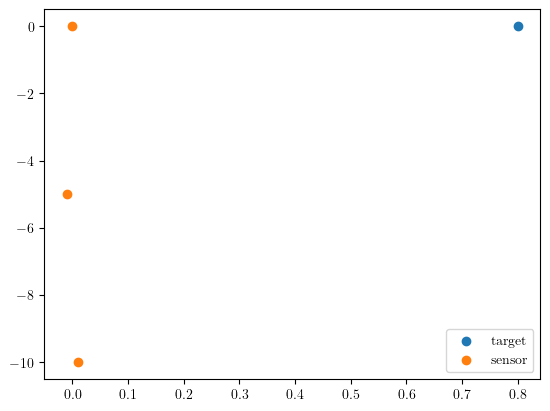

In [11]:
#Settings
range_u_s = [-0.015,0.015]
range_u_t = [-0.01,0.01]
q = q_alpha_d(2)
range_v = [-np.sqrt(2*q),np.sqrt(2*q)]

sensor_torch = RangingSensor2DT()
sensor_np = RangingSensor2D()

lr_t = 0.01
lr_s = 0.03
xs = torch.tensor(np.array([[0.,0.,0.,0.],
        [-0.01, -5, 0, 0],
        [0.01,  -10,0, 0]])).T
xt = torch.tensor(np.array([[ 0.8,0,0,0]])).T

plt.scatter(xt[0,:],xt[1,:],label='target')
plt.scatter(xs[0,:],xs[1,:],label='sensor')
plt.legend()

In [12]:
#u_s1 = robustmove_samp(xs,xt,lr_t,range_u_s,range_u_t,sensor_torch,target_torch)

In [ ]:
u_s1

In [15]:
u_s2,_ = robustmove(1,sensor_torch,target2D_torch,xs,xt,lr_s,lr_t,range_u_s,range_u_t,range_v,torch.zeros((1,4,4)),torch.ones(1),3)

In [16]:
u_s2

tensor([[[ 5.0624e-05,  8.5006e-05, -1.6277e-04],
         [ 7.2892e-05,  1.1125e-04,  2.8732e-06],
         [ 1.4943e-02,  1.4925e-02,  1.4926e-02],
         [ 1.4925e-02, -1.4924e-02, -1.4923e-02]]])

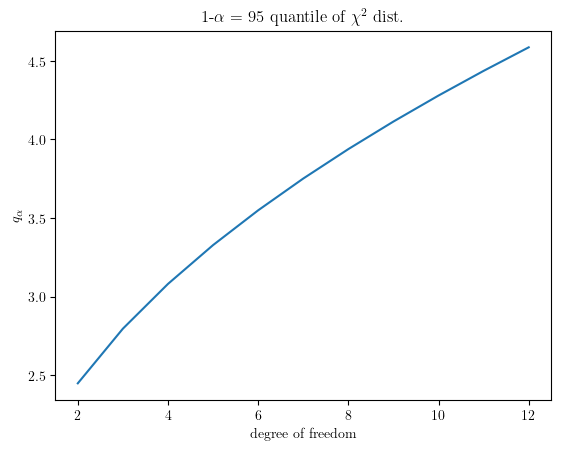

In [14]:
plt.ylabel('$q_\\alpha$')
plt.xlabel('degree of freedom')
plt.title('1-$\\alpha$ = 95 quantile of $\chi^2$ dist.')
plt.plot(range(2,13),[q_alpha_d(d) for d in range(2,13)])

## Simulation and Evaluation

In [17]:
def plot_trajectories(ax,title,targets,sensors,ests,xlim,ylim,n_ranging_sensors):
    ax.scatter(targets[:,0,:], targets[:,1,:],c='blue',alpha=0.02)
    ax.scatter(targets[-1,0,:], targets[-1,1,:],c='blue',alpha=1,label='Target')
    
    if n_ranging_sensors>0:
        ax.scatter(sensors[:,0,:n_ranging_sensors], sensors[:,1,:n_ranging_sensors], alpha=0.02,c='orange')
        ax.scatter(sensors[-1,0,:n_ranging_sensors], sensors[-1,1,:n_ranging_sensors], alpha=1,c='orange',label='Ranging sensors')
    
    if n_ranging_sensors==0 or n_ranging_sensors<sensors.shape[1]:
        ax.scatter(sensors[:,0,n_ranging_sensors:], sensors[:,1,n_ranging_sensors:], alpha=0.02,c='green')
        ax.scatter(sensors[-1,0,n_ranging_sensors:], sensors[-1,1,n_ranging_sensors:], alpha=1,c='green',label='Doppler sensors')
    
    ax.scatter(ests[:,0,:], ests[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')
    ax.set_title(title)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel('$p_x$ [m]')
    ax.set_ylabel('$p_y$ [m]')
    
def plotframe(T,frame,costs,rect,n_range_sensors):
    fig = plt.figure(figsize=(12,6))
    
    ax = plt.subplot(1,2,1)

    dim,n_target = frame['est']
    for nt in n_target:
        ax.add_patch(Circle((frame['target'][0,nt],frame['target'][1,nt]), 3, color='blue',label='target'))
        ax.add_patch(Circle((frame['est'][0,nt], frame['est'][1,nt]), 4, alpha=0.1, color='red',label='estimated target'))
    
    sensors = frame['sensor']
    obs = frame['obs']
    
    for i in range(n_range_sensors):
        c = (sensors[0,i], sensors[1,i])
        r = obs[0,i]
        ax.add_patch(Circle(c, 3, color='orange'))
    
    for i in range(sensors.shape[1]-n_range_sensors):
        c = (sensors[0,i+n_range_sensors], sensors[1,i+n_range_sensors])
        ax.add_patch(Circle(c, 3, color='green'))
    
    plt.title(f'T={frame["t"]}/{T}')
    plt.ylim(rect[2],rect[3])
    plt.xlim(rect[0],rect[1])
    plt.legend()
    
    ax1 = plt.subplot(1,2,2)
    ax1.plot(range(1,frame['k']+1),costs[:frame['k']],label='estimation error',c='orange')
    ax1.set_ylim(min(costs),max(costs))
    ax1.set_ylabel('absolute estimation error')
    ax1.legend(loc='center left')
    ax1.set_yscale('log')
    
    plt.xlim(1,len(costs)+1)
    plt.title('Time-Cost')
    plt.xlabel('T')
    
    plt.savefig(f'./img/img_{frame["t"]}.png', 
                    transparent = False,  
                    facecolor = 'white'
                   )
    fig.clf()
    plt.close(fig)
    
def plotgif(T,frames,costs,rect,prefix,n_range_sensors):
    gif_imgs = []
    for frame in frames:
        plotframe(T,frame,costs,rect,n_range_sensors)
        gif_imgs.append(imageio.v2.imread(f'./img/img_{frame["k"]}.png'))
    
    imageio.mimsave(f'./{prefix}_T={T}.gif',gif_imgs,fps = 4)  
    
def extract_costs(frames):
    position_err = []
    sensor_trac = []
    target_trac = []
    est_trac = []
    velocity_err = []
    crb_rmse_p = []
    crb_rmse_v = []
    est_status = []
    dim = frames[0]['target'].shape[0]//2
    for frame in frames:
        pe = np.linalg.norm(frame['target'][:dim]-frame['est'][:dim],axis=0)
        position_err.append(pe)
        sensor_trac.append(frame['sensor'])
        target_trac.append(frame['target'])
        est_trac.append(frame['est'])
        crb_rmse_p.append(frame['crb_rmse_p'])
        crb_rmse_v.append(frame['crb_rmse_v'])
        est_status.append(frame['est_status'])
        
        ve = np.linalg.norm(frame['target'][dim:]-frame['est'][dim:],axis=0)
        velocity_err.append(ve)
            
    ret = {'sensors':array(sensor_trac)
           ,'targets':array(target_trac)
           ,'ests':array(est_trac)
           ,'est_status':array(est_status)
          ,'rmse_p':array(position_err)
          ,'crb_rmse_p':array(crb_rmse_p)
          ,'rmse_v':array(velocity_err)
          ,'crb_rmse_v':array(crb_rmse_v)}
    
    return ret

In [36]:
def tracking_robust(T,K,sensor_torch,target_torch,sensor_np,target_np,lr_s,lr_t,rs,rt,rv,w,trajectory,est_0,dim,n_dynamic_sensors,robust=True,gamma=1):
    frames = []
    
    x_t_n,x_s_n,u_t = trajectory(T)
    previous_est = est_0
   
    for t in tnrange(T):
        frame = {}
        
        frame['target'] = x_t_n
        frame['sensor'] = x_s_n
        
        #STEP 1. read observaion
        obs = observe(sensor_np.hx(x_t_n,x_s_n),sensor_np.sx(x_t_n,x_s_n))
        frame['obs'] = obs
        
        #STEP 2. estimate target
        est,C_sqt,status = estimate_mle(sensor_np,x_s_n,obs,previous_est)
        
        if isinstance(sensor_np,RangingSensor2D) or isinstance(sensor_np,RangingSensor3DFull) or isinstance(sensor_np,RangingSensor3D2D):
            velocity = est[dim:,:]-previous_est[dim:,:]
            est[dim:,:] = velocity
        
        frame['est'] = est
        frame['C_sqt'] = C_sqt
        frame['est_status'] = status
        
        x_s_n_prev = x_s_n.copy()
        previous_est = est.copy()
        
        #STEP 3. plan nextmove
        x_s = torch.tensor(x_s_n)
        
        if robust:
            u_s,_ = robustmove(K,sensor_torch,target_torch,x_s,torch.tensor(est),lr_s,lr_t,rs,rt,rv,torch.tensor(C_sqt),w,n_dynamic_sensors,ekf=False,gamma=gamma)
        else:
            u_s,_ = move(K,sensor_torch,target_torch,x_s,torch.tensor(est),lr_s,rs,rt,torch.tensor(C_sqt),w,n_dynamic_sensors,is_target=False,ekf=False,gamma=gamma)
                    
        #STEP 4. sensor act
        #print(x_s_n,u_s[0])
        x_s_n = sensor_np.transition(x_s_n,u_s[0].numpy())
        x_s = torch.tensor(x_s_n)
        #print(x_s_n)
        #STEP 5. target act
        x_t_n = target_np.transition(x_t_n,u_t[:,:,t])
        
        #6. evaluate 
        compute_crbv = (isinstance(sensor_np,MixedRangingDoppler3DFull)
                        |isinstance(sensor_np,DopplerSensor3D2D)
                        |isinstance(sensor_np,DopplerSensorFull))
        crb_rmse_p,crb_rmse_v = crlb_rmse(compute_crbv,sensor_np.hx(x_t_n,x_s_n),sensor_np.sx(x_t_n,x_s_n),sensor_np.H(x_t_n,x_s_n),sensor_np.S(x_t_n,x_s_n))
        frame['crb_rmse_p'] = crb_rmse_p
        frame['crb_rmse_v'] = crb_rmse_v
        
        frame['t'] = t
        frames.append(frame)
    return frames

In [19]:
def case_2D_1(K):
    points =  np.array([[-5,0],[-2.5,5],[0,20],[2,23],[15,0],[12,-5],[5,0],[0,5],[-15,10]])
    _,_,a = trajectory_generator_2D(points,K+1,0)
    
    x_t = zeros((4,1))
    x_t[0,:] = -5
    x_t[1,:] = 0
    
    x_s = zeros((4,3))
    
    x_s[0,0] = -5.01
    x_s[0,1] = -5
    x_s[0,2] = -4.99
    x_s[1,0] = -5
    x_s[1,1] = -10
    x_s[1,2] = -15
    
    u_t = zeros((4,1,K))
    u_t[2,:,:] = a[:,0]
    u_t[3,:,:] = a[:,1]
    return x_t,x_s,u_t

In [20]:
K=3
range_u_s = [-0.01,0.01]
lr_t = 0.01
lr_s = 0.03

lambd = 0.8
w = torch.tensor([np.power(lambd,(-k-1)) for k in range(K)])

In [21]:
previous_est = array([[-10.,3, 0, 0]]).T

dim = 2

bn = 1.52*np.sqrt(dim)
range_u_t = [-bn,bn]

q = np.sqrt(dim*q_alpha_d(dim))
range_v = [-q,q]

T = 100 
trajectory = case_2D_1
n_dynamic_sensors = 3

sensor_torch = RangingSensor2DT()
sensor_np = RangingSensor2D()


In [ ]:
frames_1 = tracking_robust(T,K,sensor_torch,target2D_torch,sensor_np,target2D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,previous_est,dim,n_dynamic_sensors)
result_1 = extract_costs(frames_1)

In [34]:
frames_1_nonrobust = tracking_robust(T,K,sensor_torch,target2D_torch,sensor_np,target2D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,previous_est,dim,n_dynamic_sensors,robust=False)
result_1_nonrobust = extract_costs(frames_1_nonrobust)

  0%|          | 0/100 [00:00<?, ?it/s]

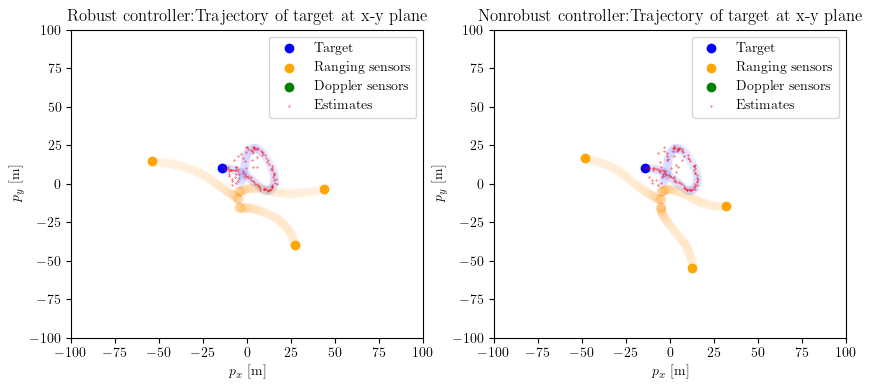

In [35]:
plt.figure(figsize=(10,4))

ax=plt.subplot(1,2,1)
title = 'Robust controller:Trajectory of target at x-y plane'
xlim = [-100,100]
ylim = [-100,100]
plot_trajectories(ax,title,result_1['targets'], result_1['sensors'],result_1['ests'],xlim,ylim,3)
plt.legend()

ax=plt.subplot(1,2,2)
title = 'Nonrobust controller:Trajectory of target at x-y plane'
xlim = [-100,100]
ylim = [-100,100]

plot_trajectories(ax,title,result_1_nonrobust['targets'], result_1_nonrobust['sensors'],result_1_nonrobust['ests'],xlim,ylim,3)
plt.legend()
#plt.savefig('one-target-trajectory.pdf')

### Plot costs

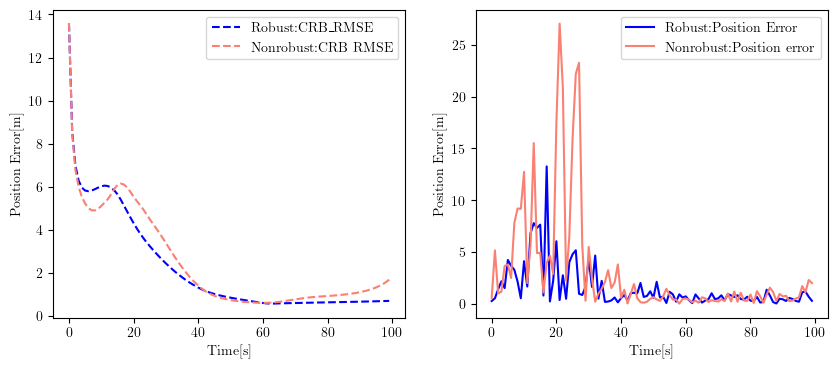

In [144]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(result_1['crb_rmse_p'],c='b',linestyle='dashed',label='Robust:CRB_RMSE')
plt.plot(result_1_nonrobust['crb_rmse_p'],c='salmon',linestyle='dashed',label='Nonrobust:CRB RMSE')
plt.xlabel('Time[s]')
plt.ylabel('Position Error[m]')
plt.legend()
plt.subplot(1,2,2)
plt.plot(result_1['rmse_p'],c='b',label='Robust:Position Error')
plt.plot(result_1_nonrobust['rmse_p'],c='salmon',label='Nonrobust:Position error')
plt.xlabel('Time[s]')
plt.ylabel('Position Error[m]')
plt.legend()

In [632]:
#mc3 = []
#mc1 = []
#mc2 = []
#mc4 = []
M = 6
for i in range(M):
    print('i=',str(i))
    trajectory = trajectory2D_2
    previous_est = array([[-10.,3, 0, 0]]).T
    
    try:
        
        frames_1 = tracking_smooth(K,3,lr_s,lr_t,w2,trajectory,previous_est)
        cost_1,sensors_1,target_1,est_1 = extract_costs(frames_1)
        mc1.append(cost_1)
    except:
        print('?',str(i))
   # try:   
   #     frames_2 = tracking_smooth(K,1,lr_s,lr_t,w2[:1],trajectory,previous_est,robust=False)
   #     cost_2,sensors_2,target_2,est_2 = extract_costs(frames_2)
   #     mc2.append(cost_2)
   # except:
   #     print('?',str(i))
        
   # try:   
   #     frames_3 = tracking_smooth(K,3,lr_s,lr_t,w2,trajectory,previous_est,robust=False)
   #     cost_3,sensors_3,target_3,est_3 = extract_costs(frames_3)
   #     mc3.append(cost_3)
   # except:
   #     print('?',str(i))
        

i= 0
i= 1
i= 2
i= 3
i= 4
? 4
i= 5
? 5


In [634]:
import pickle
with open('single_target_ranging_sensor_3.pk','wb') as f:
    pickle.dump(np.array(mc1[:100]),f)
#single_target_ranging_sensor_2_ekf
#with open('single_target_ranging_sensor_2_nonrobust_1step.pk','wb') as f:
#    pickle.dump(np.array(mc2[:100]),f)

#with open('single_target_ranging_sensor_2_nonrobust.pk','wb') as f:
#    pickle.dump(np.array(mc3[:100]),f)
    

In [635]:
with open('single_target_ranging_sensor_2.pk','rb') as f:
    costs_mc1=pickle.load(f)
    
with open('single_target_ranging_sensor_2_nonrobust_1step.pk','rb') as f:
    costs_mc2=pickle.load(f)

with open('single_target_ranging_sensor_2_nonrobust.pk','rb') as f:
    costs_mc3=pickle.load(f)
    
with open('single_target_ranging_sensor_3.pk','rb') as f:
    costs_mc4=pickle.load(f)
    

In [636]:
costs_mc_std1 = costs_mc1.std(axis=0)
costs_mc_mean1 = costs_mc1.mean(axis=0)
costs_mc_q_51 = np.quantile(costs_mc1,0.05,axis=0)
costs_mc_q_951= np.quantile(costs_mc1,0.95,axis=0)

costs_mc_std2 = costs_mc2.std(axis=0)
costs_mc_mean2 = costs_mc2.mean(axis=0)
costs_mc_q_52 = np.quantile(costs_mc2,0.05,axis=0)
costs_mc_q_952= np.quantile(costs_mc2,0.95,axis=0)

costs_mc_std3 = costs_mc3.std(axis=0)
costs_mc_mean3 = costs_mc3.mean(axis=0)
costs_mc_q_53 = np.quantile(costs_mc3,0.05,axis=0)
costs_mc_q_953= np.quantile(costs_mc3,0.95,axis=0)

costs_mc_std4 = costs_mc4.std(axis=0)
costs_mc_mean4 = costs_mc4.mean(axis=0)
costs_mc_q_54 = np.quantile(costs_mc4,0.05,axis=0)
costs_mc_q_954= np.quantile(costs_mc4,0.95,axis=0)

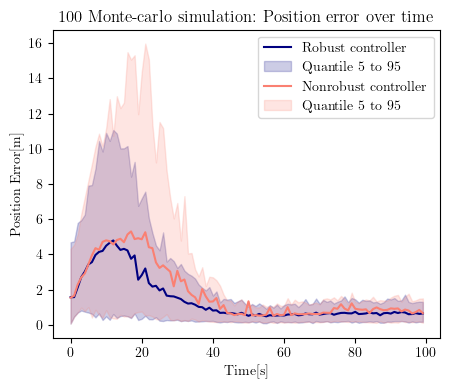

In [642]:
plt.figure(figsize=(5,4))
plt.title('100 Monte-carlo simulation: Position error over time')
plt.plot(costs_mc_mean4,c='navy',label='Robust controller')
plt.fill_between(range(100),costs_mc_q_54.flatten(), costs_mc_q_954.flatten(),alpha=0.2,color='navy',label='Quantile 5 to 95')
plt.plot(costs_mc_mean3,label='Nonrobust controller',c='salmon')
plt.fill_between(range(100),costs_mc_q_53.flatten(), costs_mc_q_953.flatten(),alpha=0.2,color='salmon',label='Quantile 5 to 95')
plt.xlabel('Time[s]')
plt.ylabel('Position Error[m]')
plt.legend()
plt.savefig('one-target-mc.pdf')

In [7]:
def smooth_3D_trajectory_1(T):
    x_s = torch.zeros((6,6))
    
    #first three sensors
    x_s[:,0] = torch.tensor([0.01,0,5,0,0,0])
    x_s[:,1] = torch.tensor([-0.01,-5,-5,0,0,0])
    x_s[:,2] = torch.tensor([0.,-10,0.,0,0,0])
    
    #last three sensors
    x_s[:,3] = torch.tensor([0.02,-2.5,0,0,0,0])
    x_s[:,4] = torch.tensor([-0.02,-7.5,0,0,0,0])
    x_s[:,5] = torch.tensor([-0.015,-12.5,0,0,0,0])
    
    
    #single target
    x_t = torch.zeros((6,1))
    x_t[:,0] = torch.tensor([0.,-20,10,1,0.5,0])
    
    #accelerations of target
    u_t =  torch.zeros((6,1,T))
    u_t[3,0,:] = 0.01
    return x_t,x_s,u_t

def smooth_3D_trajectory_2(K):
    x_s = torch.zeros((6,6))
    
    x_s[0,0] = 0.01
    x_s[0,1] = -0.1
    x_s[0,2] = 0.0
    x_s[0,3] = 0.013
    x_s[0,4] = -0.12
    x_s[0,5] = 0.03
    
    x_s[1,0] = 0
    x_s[1,1] = -5
    x_s[1,2] = -10
    x_s[1,3] = -2.5
    x_s[1,4] = -7.5
    x_s[1,5] = -12.5
    
    x_s[2,0] = 5
    x_s[2,1] = -5
    x_s[2,5] = 6
  
    x_t = torch.zeros((6,1))
    x_t[0,:] = 0
    x_t[1,:] = 10
    x_t[2,:] = 10
    
    x_t[3,:] = 0.5
    
    u_t =  torch.zeros((6,1,K))
    u_t[3,:,:] = -1/K
    u_t[4,:,:int(K/2)] = -1/K
    u_t[4,:,int(K/2):] = 1/K
    return x_t,x_s,u_t

def smooth_3D_trajectory_3(K):
    x_s = torch.zeros((6,7))
    
    x_s[0,0] = 0.01
    x_s[0,1] = -0.01
    x_s[0,2] = 0.0
    x_s[0,3] = 0.02
    x_s[0,4] = -0.02
    x_s[0,5] = -0.015
    x_s[0,6] = 0.001
    
    x_s[1,0] = 0
    x_s[1,1] = -5
    x_s[1,2] = -10
    x_s[1,3] = -2.5
    x_s[1,4] = -7.5
    x_s[1,5] = -12.5
    x_s[1,6] = 2.5
    
    x_s[2,0] = 5
    x_s[2,1] = -5
    x_s[2,2] = 20
  
    x_t = torch.zeros((6,2))
    x_t[0,:] = 0
    x_t[1,:] = 10
    x_t[2,:] = 10
    
    x_t[3,:] = 0.5
    #x_t[5,:] = 0.5
    
    u_t =  torch.zeros((6,2,K))
    u_t[3,:,:] = -1/K
    u_t[4,0,:int(K/2)] = -1/K
    u_t[4,0,int(K/2):] = 1/K
    u_t[4,1,:int(K/2)] = 1/K
    u_t[4,1,int(K/2):] = -1/K
    return x_t,x_s,u_t

def smooth_3D_trajectory_4(K):
    x_s = torch.zeros((6,7))
    
    x_s[0,0] = 0.01
    x_s[0,1] = -0.01
    x_s[0,2] = 0.0
    x_s[0,3] = 0.02
    x_s[0,4] = -0.02
    x_s[0,5] = -0.015
    x_s[0,6] = 0.001
    
    x_s[1,0] = 0
    x_s[1,1] = -5
    x_s[1,2] = -10
    x_s[1,3] = -2.5
    x_s[1,4] = -7.5
    x_s[1,5] = -12.5
    x_s[1,6] = 2.5
    
    x_s[2,0] = 5
    x_s[2,1] = -5
    x_s[2,2] = 20
  
    x_t = torch.zeros((6,2))
    x_t[0,:] = 0
    x_t[1,0] = 10
    x_t[2,:] = 10
    x_t[1,1] = 0
    x_t[3,:] = 0.5
    #x_t[5,:] = 0.5
    
    u_t =  torch.zeros((6,2,K))
    u_t[3,:,:] = -1/K
    u_t[4,0,:int(K/2)] = -1/K
    u_t[4,0,int(K/2):] = 1/K
    
    u_t[4,1,:int(K/2)] = -1/K
    u_t[4,1,int(K/2):] = 1/K
    return x_t,x_s,u_t

def smooth_3D_trajectory_5(K):
    x_s = torch.zeros((6,4))
    
    x_s[0,0] = 0.01
    x_s[0,1] = -0.01
    x_s[0,2] = 0.0
    x_s[0,3] = 0.02
    
    x_s[1,0] = 0
    x_s[1,1] = -5
    x_s[1,2] = -10
    x_s[1,3] = -2.5
    
    x_s[2,0] = 5
    x_s[2,1] = -5
    x_s[2,2] = 20
  
    x_t = torch.zeros((6,2))
    x_t[0,:] = 0
    x_t[1,:] = 10
    x_t[2,:] = 10
    
    x_t[3,:] = 0.5
    #x_t[5,:] = 0.5
    
    u_t =  torch.zeros((6,2,K))
    u_t[3,:,:] = -1/K
    u_t[4,0,:int(K/2)] = -1/K
    u_t[4,0,int(K/2):] = 1/K
    u_t[4,1,:int(K/2)] = 1/K
    u_t[4,1,int(K/2):] = -1/K
    return x_t,x_s,u_t

def smooth_3D_trajectory_6(K):
    x_s = torch.zeros((6,4))
    
    x_s[0,0] = 0.01
    x_s[0,1] = -0.01
    x_s[0,2] = 0.0
    x_s[0,3] = 0.02
    
    x_s[1,0] = 2.5
    x_s[1,1] = -2.5
    x_s[1,2] = -5
    x_s[1,3] = 5
    
    x_s[2,0] = 5
    x_s[2,1] = -5
    x_s[2,2] = 20
  
    x_t = torch.zeros((6,2))
    x_t[0,:] = 0
    x_t[1,:] = 10
    x_t[2,:] = 10
    
    
    _,_,_,u1 = trajectory_spiral_3D(np.array([0,10,10]),K+1,1)
    _,_,_,u2 = trajectory_spiral_3D(np.array([0,10,10]),K+1,-1)
    
    u_t =  torch.zeros((6,2,K))
    u_t[3,0,:] = torch.tensor(u1[:,0])
    u_t[4,0,:] = torch.tensor(u1[:,1])
    u_t[5,0,:] = torch.tensor(u1[:,2])
    u_t[3,1,:] = torch.tensor(u2[:,0])
    u_t[4,1,:] = torch.tensor(u2[:,1])
    u_t[5,1,:] = torch.tensor(u2[:,2])
    return x_t,x_s,u_t

def smooth_3D_trajectory_7(K):
    x_s = torch.zeros((6,7))
    
    x_s[0,0] = 0.01
    x_s[0,1] = -0.01
    x_s[0,2] = 0.0
    x_s[0,3] = 0.013
    x_s[0,4] = -0.12
    x_s[0,5] = 0.01
    
    x_s[1,0] = 0
    x_s[1,1] = -5
    x_s[1,2] = -10
    x_s[1,3] = -2.5
    x_s[1,4] = -7.5
    x_s[1,5] = -8
    x_s[1,6] = -10
    
    x_s[2,0] = 5
    x_s[2,1] = -5
    x_s[2,5] = 9
  
    x_t = torch.zeros((6,1))
    x_t[0,:] = 0
    x_t[1,:] = 10
    x_t[2,:] = 10
    
    x_t[3,:] = 0.5
    
    u_t =  torch.zeros((6,1,K))
    u_t[3,:,:] = -1/K
    u_t[4,:,:int(K/2)] = -1/K
    u_t[4,:,int(K/2):] = 1/K
    return x_t,x_s,u_t


def smooth_3D_trajectory_8(T):
    
    x_s = torch.zeros((6,7))
    #first 4 sensors
    x_s[:,0] = torch.tensor([0.01,0.,5.,0,0,0])
    x_s[:,1] = torch.tensor([-10.,-5,-5,0,0,0])
    x_s[:,2] = torch.tensor([20.,-10,9,0.,0.,0.])
    x_s[:,3] = torch.tensor([0.013,-2.5,0.,0.,0.,0.])
    
    #last 3 sensors
    x_s[:,4] = torch.tensor([0.,-0.001,0.,0.,0.,0.])
    x_s[:,5] = torch.tensor([-0.01,-0.002,0.01,0.,0.,0.])
    x_s[:,6] = torch.tensor([0.002,0.,0.03,0.,0.,0.])

    
    #single target
    x_t = torch.zeros((6,1))
    x_t[:,0] = torch.tensor([50.,0.,10,0.,0.,0.])
  
    #accelerations   
    u_t =  torch.zeros((6,1,T))
    
    _,_,_,us = trajactory_Tangential_3D(np.array([50.,0.,10.]),T,50,0.5*np.pi)
    
    u_t[3,:,:] = torch.tensor(us[:,0])
    u_t[4,:,:] = torch.tensor(us[:,1])
    u_t[5,:,:] = torch.tensor(us[:,2])
    return x_t,x_s,u_t

def smooth_3D_trajectory_9(T):
    
    x_s = zeros((6,6))
    x_s[:,0] = array([0.,0.001,107.,0.,0.,0.])
    x_s[:,1] = array([-200,-100,3,0.,0.,0.])
    x_s[:,2] = array([400.,-200.,-3,0.,0.,0.])
    x_s[:,3] = array([-10.015,40.,-0.01,0.,0.,0.])
    x_s[:,4] = array([-30.3,-170.,-150.05,0.,0.,0.])
    x_s[:,5] = array([0.012,130.012,-5.1,0.,0.,0.])

    
    #single target
    r = 500.
    x_t = zeros((6,1))
    x_t[:,0] = array([-r,0.,10,0.,0.,0.])
  
    #accelerations   
    u_t =  zeros((6,1,T))
    
    _,_,_,a = trajactory_Tangential_3D(np.array([-r,0.,10.]),T,r,T/100.*np.pi)
    
    a= -a
    
    u_t[3,:,:] = a[:,0]
    u_t[4,:,:] = a[:,1]
    u_t[5,:,:] = a[:,2]
    return x_t,x_s,u_t

def smooth_3D_trajectory_10(T):
    x_s = torch.zeros((6,6))
    x_s[:,0] = torch.tensor([0.,-20.001,7.,0.,0.,0.])
    x_s[:,1] = torch.tensor([-10.01,-0.002,0.01,0.,0.,0.])
    x_s[:,2] = torch.tensor([40.002,0.,0.03,0.,0.,0.])
    x_s[:,3] = torch.tensor([-0.015,10.,-0.01,0.,0.,0.])
    x_s[:,4] = torch.tensor([-0.3,0.,-5.05,0.,0.,0.])
    x_s[:,5] = torch.tensor([0.012,30.012,-5.1,0.,0.,0.])
    
    #single target
    x_t = torch.zeros((6,1))
    x_t[:,0] = torch.tensor([0.,-20,10,1,0.5,0])
    
    #accelerations of target
    u_t =  torch.zeros((6,1,T))
    u_t[3,0,:] = 0.01
    return x_t,x_s,u_t



def smooth_3D_trajectory_11(T):
    
    x_s = zeros((6,6))
    #static sensors as base
    x_s[:,0] = array([750.,500.001,107.,0.,0.,0.])
    x_s[:,1] = array([400,0,3,0.,0.,0.])
    x_s[:,0] = array([1000.,-250.,-3,0.,0.,0.])
    
    #vertical aligned sensors move towards right
    x_s[:,3] = array([-750,0.01,-5.,2.,0.,0.])
    x_s[:,4] = array([-750.03,-100.,-5.05,2.,0.,0.])
    x_s[:,5] = array([-750.02,-200.012,-5.1,2.,0.,0.])

    
    #single target
    x_t = zeros((6,1))
    x_t[:,0] = array([850,-100.,-5,-1.,0.,0.])
  
    #accelerations 
    points = np.array([[850,-100],[400,-110],[0,0],[-150.,250],[-100,700]])
    _,_,a = trajectory_generator_2D(points,101,0)
    u_t =  zeros((6,1,T))
    
    
    u_t[3,:,:] = a[:,0]
    u_t[4,:,:] = a[:,1]
    return x_t,x_s,u_t

In [8]:
K = 3

lr_t = 0.01
lr_s = 0.03


lambd = 1.2
w = torch.tensor([np.power(lambd,(-k-1)) for k in range(K)])

In [86]:
#range_u_s = [-0.02,0.02]
# dim = 6
# bn = 0.01*np.sqrt(dim)
# range_u_t = [-bn,bn]

# q = np.sqrt(dim*q_alpha_d(dim))
# range_v = [-q,q]

# T = 100
# trajectory = smooth_3D_trajectory_1
# previous_est = array([[15 ,2 ,15 ,0, 0, 0]]).T#

In [87]:
#range_u_s = [-0.02,0.02]
# dim = 6
# bn = 1.57*np.sqrt(dim)
# range_u_t = [-bn,bn]

# q = np.sqrt(dim*q_alpha_d(dim))
# range_v = [-q,q]

# T = 50
# trajectory = smooth_3D_trajectory_8
# previous_est = array([[15 ,2 ,15 ,0, 0, 0]]).T#

#n_range_sensors = 4
#sensor_helper = EnsembledSensor3DTorchUtils_2(n_range_sensors)
#sensor_simulator = EnsembledSensors3D_2(n_range_sensors,zeros((6,7)))

In [35]:
range_u_s = [-0.3,0.3]

xdim = 6
bn = 5*np.pi*np.sqrt(xdim)
range_u_t = [-bn,bn]

q = np.sqrt(xdim*q_alpha_d(xdim))
range_v = [-q,q]

T = 100
trajectory = smooth_3D_trajectory_9
n_static = 3
n_range_sensors = 0
n_dynamic_sensors = 3
x0_ = trajectory(T)[0]
sigma_init2 = 250**2
x0_guess = np.zeros(x0_.shape)
x0_guess[:2,:] = multivariate_normal.rvs(mean=x0_[:2,:].flatten(), cov=np.eye(2*x0_.shape[1])*sigma_init2).reshape((2,x0_.shape[1]))
print('initial_guess',x0_guess)
print('true location',x0_)

sensor_torch = DopplerSensorFullT(n_static=n_static)
sensor_np = DopplerSensorFull(n_static=n_static)

initial_guess [[-448.25355685]
 [ -90.03224946]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]]
true location [[-500.]
 [   0.]
 [  10.]
 [   0.]
 [   0.]
 [   0.]]


In [36]:
frames_2 = tracking_robust(T,K,sensor_torch,target3D_torch,sensor_np,target3D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x0_guess,3,n_dynamic_sensors)

7.989527940750122
96
7.880963087081909
97
7.850388050079346
98
7.779894113540649
99
7.810320854187012


In [39]:
result_2 = extract_costs(frames_2)

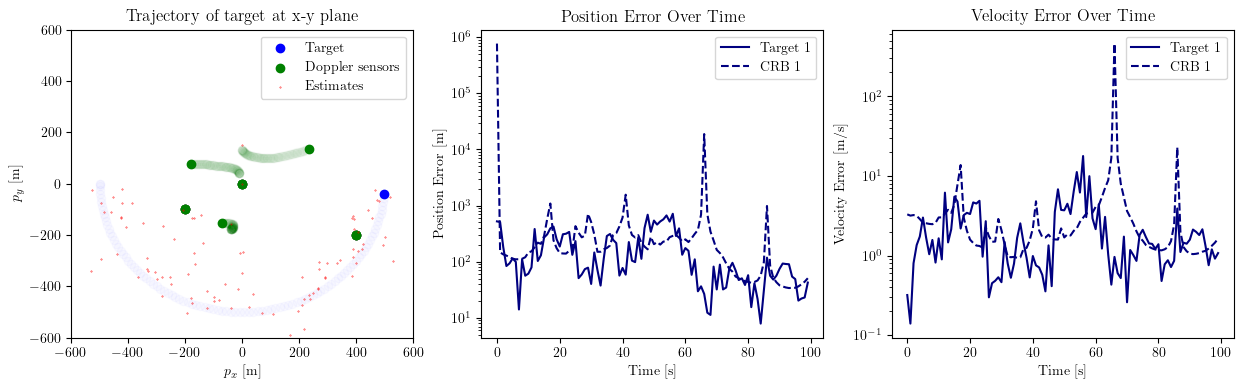

In [40]:
plt.figure(figsize=(15,4))

ax=plt.subplot(1,3,1)
title = 'Trajectory of target at x-y plane'
xlim = [-600,600]
ylim = [-600,600]
plot_trajectories(ax,title,result_2['targets'], result_2['sensors'],result_2['ests'],xlim,ylim,0)
plt.legend()

ax=plt.subplot(1,3,2)
plt.plot(result_2['rmse_p'],c='Navy',label='Target 1')
plt.plot(result_2['crb_rmse_p'],c='Navy',linestyle='dashed',label='CRB 1')
plt.xlabel('Time [s]')
plt.ylabel('Position Error [m]')
plt.yscale('log')
plt.title('Position Error Over Time')
plt.legend()

ax=plt.subplot(1,3,3)
plt.plot(result_2['rmse_v'],c='Navy',label='Target 1')
plt.plot(result_2['crb_rmse_v'],c='Navy',linestyle='dashed',label='CRB 1')
plt.xlabel('Time [s]')
plt.ylabel('Velocity Error [m/s]')
plt.title('Velocity Error Over Time')
plt.yscale('log')
plt.legend()

In [120]:
range_u_s = [-0.3,0.3]

xdim = 6
bn = 0.3*np.sqrt(xdim)
range_u_t = [-bn,bn]

q = np.sqrt(xdim*q_alpha_d(xdim))
range_v = [-q,q]

T = 100
trajectory = smooth_3D_trajectory_11
n_static = 3
n_range_sensors = 0
n_dynamic_sensors = 3
x0_ = trajectory(T)[0]
sigma_init2 = 250**2
x0_guess = np.zeros(x0_.shape)
x0_guess[:2,:] = multivariate_normal.rvs(mean=x0_[:2,:].flatten(), cov=np.eye(2*x0_.shape[1])*sigma_init2).reshape((2,x0_.shape[1]))
print('initial_guess',x0_guess)
print('true location',x0_)

sensor_torch = DopplerSensorFullT(n_static=n_static)
sensor_np = DopplerSensorFull(n_static=n_static)

initial_guess [[ 836.42794488]
 [-177.72576249]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]]
true location [[ 850.]
 [-100.]
 [  -5.]
 [  -1.]
 [   0.]
 [   0.]]


In [121]:
frames_3 = tracking_robust(T,K,sensor_torch,target3D_torch,sensor_np,target3D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x0_guess,3,n_dynamic_sensors)

7.867815017700195
91
7.785651922225952
92
7.776010990142822
93
7.801748037338257
94
7.797902822494507
95
7.813025951385498
96
7.769467115402222
97
7.748553276062012
98
7.791290044784546
99
8.847237825393677


In [122]:
result_3 = extract_costs(frames_3)

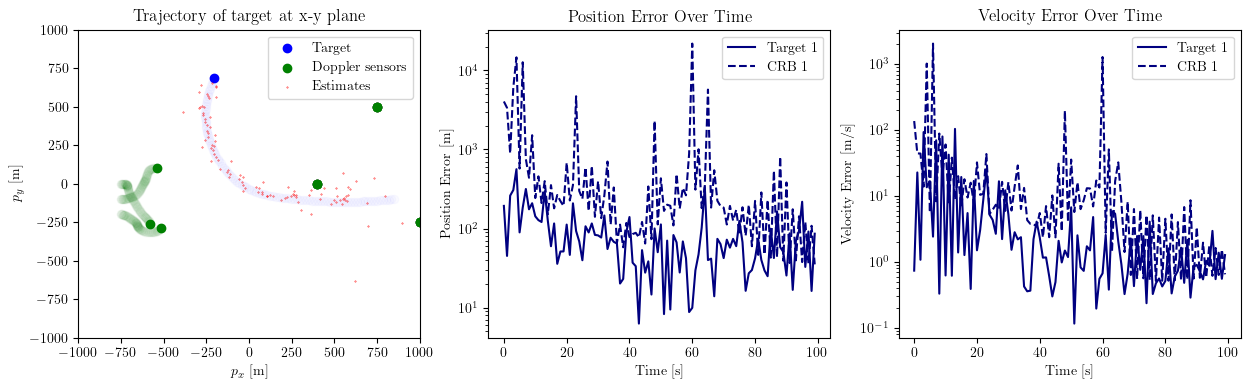

In [123]:
plt.figure(figsize=(15,4))

ax=plt.subplot(1,3,1)
title = 'Trajectory of target at x-y plane'
xlim = [-1000,1000]
ylim = [-1000,1000]
plot_trajectories(ax,title,result_3['targets'], result_3['sensors'],result_3['ests'],xlim,ylim,0)
plt.legend()

ax=plt.subplot(1,3,2)
plt.plot(result_3['rmse_p'],c='Navy',label='Target 1')
plt.plot(result_3['crb_rmse_p'],c='Navy',linestyle='dashed',label='CRB 1')
plt.xlabel('Time [s]')
plt.ylabel('Position Error [m]')
plt.yscale('log')
plt.title('Position Error Over Time')
plt.legend()

ax=plt.subplot(1,3,3)
plt.plot(result_3['rmse_v'],c='Navy',label='Target 1')
plt.plot(result_3['crb_rmse_v'],c='Navy',linestyle='dashed',label='CRB 1')
plt.xlabel('Time [s]')
plt.ylabel('Velocity Error [m/s]')
plt.title('Velocity Error Over Time')
plt.yscale('log')
plt.legend()

In [37]:
def case_3D_12(T):
    
    x_s = zeros((6,6))
    #static sensors as base
    x_s[:,0] = array([1000.,-250.,-3,0.,0.,0.])
    
    #static dopper to fulfill rank
    x_s[:,1] = array([1001.,-253.,-3.2,0.,0.,0.])
    x_s[:,2] = array([999.,-251.,-3,0.,0.,0.])
    
    #vertical aligned sensors move towards right
    x_s[:,3] = array([-750,0.01,-5.,2.,0.,0.])
    x_s[:,4] = array([-750.03,-100.,-5.05,2.,0.,0.])
    x_s[:,5] = array([-750.02,-200.012,-5.1,2.,0.,0.])

    
    #single target
    x_t = zeros((6,1))
    x_t[:,0] = array([850,-100.,-5,-1.,0.,0.])
  
    #accelerations 
    points = np.array([[850,-100],[400,-110],[0,0],[-150.,250],[-100,700]])
    _,_,a = trajectory_generator_2D(points,101,0)
    u_t =  zeros((6,1,T))
    
    
    u_t[3,:,:] = a[:,0]
    u_t[4,:,:] = a[:,1]
    return x_t,x_s,u_t


In [38]:
K = 3

lr_t = 0.01
lr_s = 0.03


lambd = 1.2
w = torch.tensor([np.power(lambd,(-k-1)) for k in range(K)])

range_u_s = [-0.3,0.3]

xdim = 6
bn = 0.3*np.sqrt(xdim)
range_u_t = [-bn,bn]

q = np.sqrt(xdim*q_alpha_d(xdim))
range_v = [-q,q]

T = 100
trajectory = case_3D_12
n_static_ranging = 1
n_static_doppler = 2
n_rangingsensor = 1
n_dynamic_sensors = 3

x0_ = trajectory(T)[0]
sigma_init2 = 250**2
x0_guess = np.zeros(x0_.shape)
x0_guess[:2,:] = multivariate_normal.rvs(mean=x0_[:2,:].flatten(), cov=np.eye(2*x0_.shape[1])*sigma_init2).reshape((2,x0_.shape[1]))
print('initial_guess',x0_guess)
print('true location',x0_)

sensor_torch = MixedRangingDoppler3DFullT(n_rangingsensor,n_static_ranging,n_static_doppler)
sensor_np = MixedRangingDoppler3DFull(n_rangingsensor,n_static_ranging,n_static_doppler)

initial_guess [[ 639.38999045]
 [-475.74420459]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]]
true location [[ 850.]
 [-100.]
 [  -5.]
 [  -1.]
 [   0.]
 [   0.]]


In [43]:
frames_4 = tracking_robust(T,K,sensor_torch,target3D_torch,sensor_np,target3D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x0_guess,3,n_dynamic_sensors)

  0%|          | 0/100 [00:00<?, ?it/s]

In [44]:
result_4 = extract_costs(frames_4)

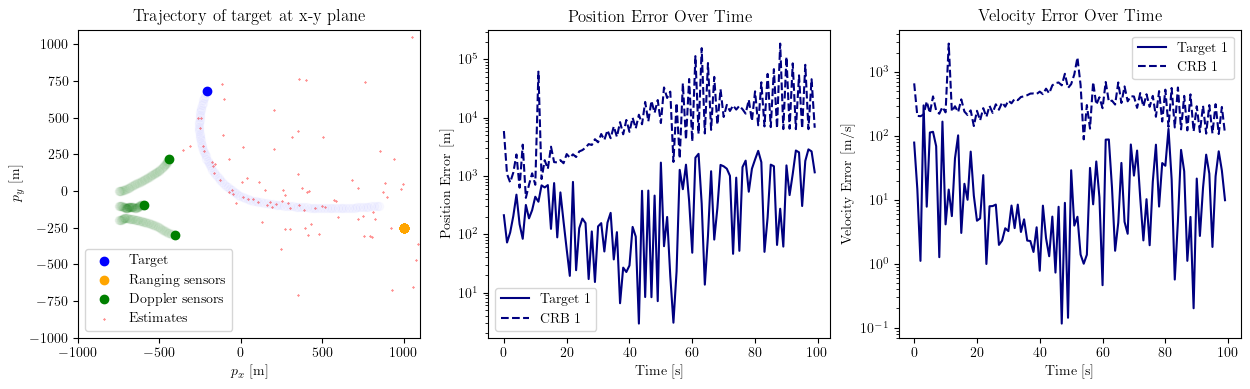

In [45]:
plt.figure(figsize=(15,4))

ax=plt.subplot(1,3,1)
title = 'Trajectory of target at x-y plane'
xlim = [-1000,1100]
ylim = [-1000,1100]
plot_trajectories(ax,title,result_4['targets'], result_4['sensors'],result_4['ests'],xlim,ylim,3)
plt.legend()

ax=plt.subplot(1,3,2)
plt.plot(result_4['rmse_p'],c='Navy',label='Target 1')
plt.plot(result_4['crb_rmse_p'],c='Navy',linestyle='dashed',label='CRB 1')
plt.xlabel('Time [s]')
plt.ylabel('Position Error [m]')
plt.yscale('log')
plt.title('Position Error Over Time')
plt.legend()

ax=plt.subplot(1,3,3)
plt.plot(result_4['rmse_v'],c='Navy',label='Target 1')
plt.plot(result_4['crb_rmse_v'],c='Navy',linestyle='dashed',label='CRB 1')
plt.xlabel('Time [s]')
plt.ylabel('Velocity Error [m/s]')
plt.title('Velocity Error Over Time')
plt.yscale('log')
plt.legend()

In [ ]:

n_range_sensors = 4
n_doppler_sensors = 3
sensor_helper = EnsembledSensor3DTorchUtils_2(n_range_sensors)
sensor_simulator = EnsembledSensors3D_2(n_range_sensors,zeros((6,7)))


previous_est = array([[15 ,2 ,15 ,0, 0, 0]]).T#

frames_6s = tracking_3D_smooth_static(K*4,3,lr_s,lr_t,w2,smooth_3D_trajectory_8,previous_est)

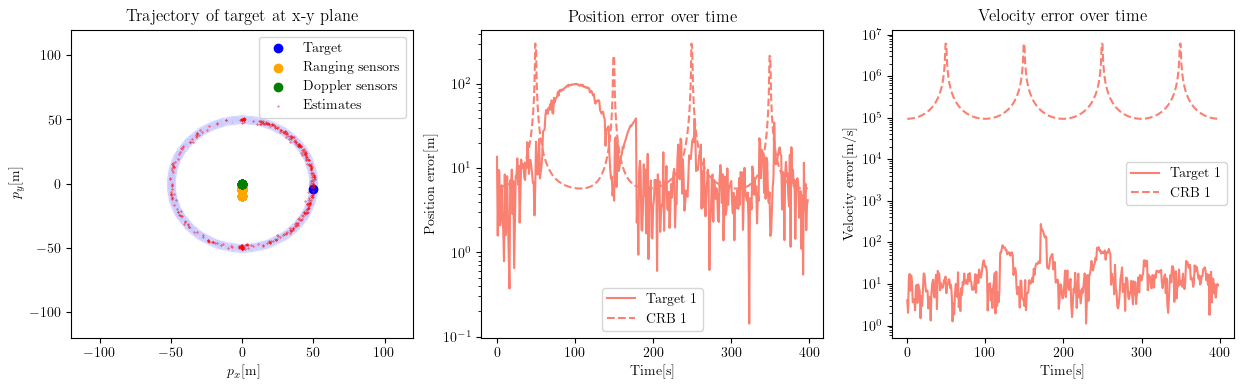

In [637]:

cost_6s,sensors_6s,target_6s,est_6s,velo_6s,crb_rmse_p_6s,crb_rmse_v_6s = extract_costs(frames_6s,True)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(target_6s[:,0,:], target_6s[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_6s[-1,0,:], target_6s[-1,1,:],c='blue',alpha=1,label='Target')

plt.scatter(sensors_6s[:,0,:n_range_sensors], sensors_6s[:,1,:n_range_sensors], alpha=0.02,c='orange')
plt.scatter(sensors_6s[-1,0,:n_range_sensors], sensors_6s[-1,1,:n_range_sensors], alpha=1,c='orange',label='Ranging sensors')
plt.scatter(sensors_6s[:,0,n_range_sensors:], sensors_6s[:,1,n_range_sensors:], alpha=0.02,c='green')
plt.scatter(sensors_6s[-1,0,n_range_sensors:], sensors_6s[-1,1,n_range_sensors:], alpha=1,c='green',label='Doppler sensors')

plt.scatter(est_6s[:,0,:], est_6s[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')


plt.title('Trajectory of target at x-y plane')
plt.xlim(-120,120)
plt.ylim(-120,120)
plt.xlabel('$p_x$[m]')
plt.ylabel('$p_y$[m]')
plt.legend(loc='best')

plt.subplot(1,3,2)
plt.plot(np.array(cost_6s)[1:],c='salmon',label='Target 1')
plt.plot(crb_rmse_p_6s[1:],c='salmon',linestyle='dashed',label='CRB 1')
#plt.plot(np.array(cost_6)[1:,1],c='navy',label='Target 2')
#plt.plot(crb_rmse_p_6[1:,1],c='navy',linestyle='dashed',label='CRB 2')
plt.xlabel('Time[s]')
plt.ylabel('Position error[m]')
plt.title('Position error over time')
plt.legend(loc='best')
plt.yscale('log')

plt.subplot(1,3,3)
plt.plot(np.array(velo_6s)[1:],c='salmon',label='Target 1')
plt.plot(crb_rmse_v_6s[1:],c='salmon',linestyle='dashed',label='CRB 1')
#plt.plot(np.array(cost_6)[1:,1],c='navy',label='Target 2')
#plt.plot(crb_rmse_p_6[1:,1],c='navy',linestyle='dashed',label='CRB 2')
plt.xlabel('Time[s]')
plt.ylabel('Velocity error[m/s]')
plt.title('Velocity error over time')
plt.legend(loc='best')
plt.yscale('log')
#plt.savefig('two-targets-mix.pdf')

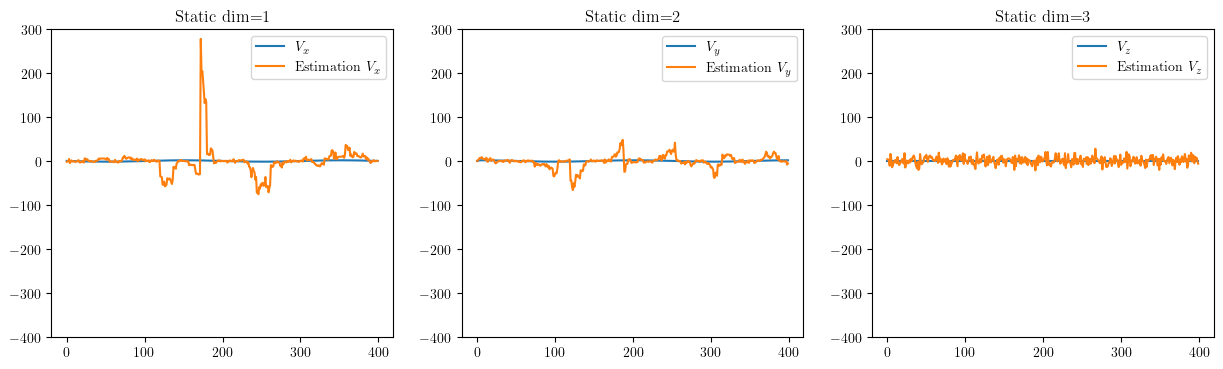

In [639]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.title('Static dim=1')
plt.plot(target_6s[:,3,0],c='C0',label='$V_x$')
plt.plot(est_6s[:,3,0],c='C1',label='Estimation $V_x$')
plt.ylim(-400,300)
plt.legend()

plt.subplot(1,3,2)
plt.title('Static dim=2')
plt.plot(target_6s[:,4,0],c='C0',label='$V_y$')
plt.plot(est_6s[:,4,0],c='C1',label='Estimation $V_y$')
plt.ylim(-400,300)
plt.legend()

plt.subplot(1,3,3)
plt.title('Static dim=3')
plt.plot(target_6s[:,5,0],c='C0',label='$V_z$')
plt.plot(est_6s[:,5,0],c='C1',label='Estimation $V_z$')
plt.ylim(-400,300)
plt.legend()

/var/folders/vf/rsnsjrs55y5b4ktf_3fc0q180000gn/T/ipykernel_39333/1061945108.py:7: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,300)
/var/folders/vf/rsnsjrs55y5b4ktf_3fc0q180000gn/T/ipykernel_39333/1061945108.py:15: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,300)


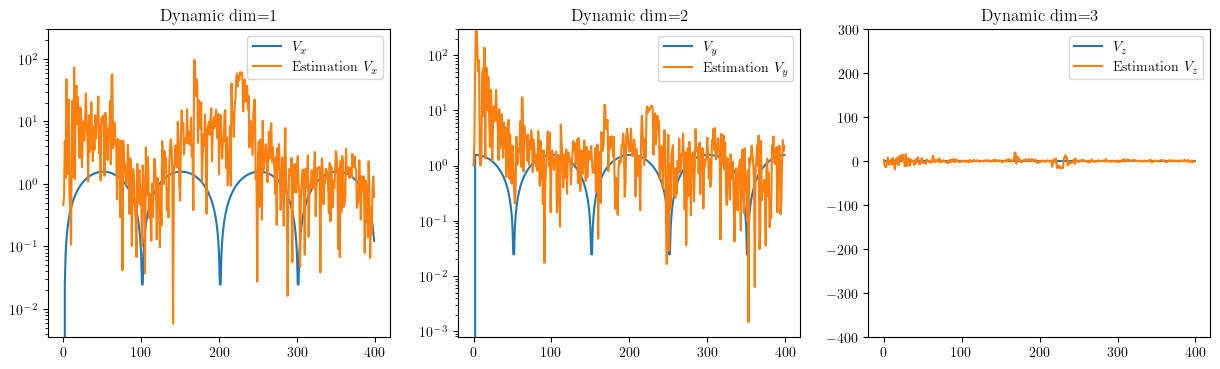

In [1552]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.title('Dynamic dim=1')
plt.plot(np.abs(target_6[:,3,0]),c='C0',label='$V_x$')
plt.plot(np.abs(est_6[:,3,0]),c='C1',label='Estimation $V_x$')
plt.yscale('log')
plt.ylim(0,300)
plt.legend()

plt.subplot(1,3,2)
plt.title('Dynamic dim=2')
plt.plot(np.abs(target_6[:,4,0]),c='C0',label='$V_y$')
plt.plot(np.abs(est_6[:,4,0]),c='C1',label='Estimation $V_y$')
plt.yscale('log')
plt.ylim(0,300)
plt.legend()

plt.subplot(1,3,3)
plt.title('Dynamic dim=3')
plt.plot(target_6[:,5,0],c='C0',label='$V_z$')
plt.plot(est_6[:,5,0],c='C1',label='Estimation $V_z$')
plt.ylim(-400,300)
plt.legend()

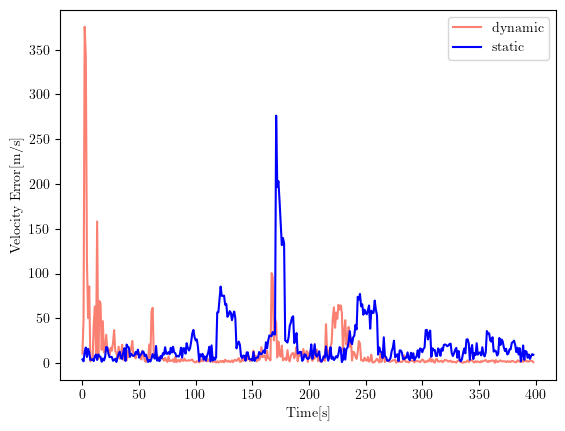

In [641]:

plt.plot(velo_6[1:],c='salmon',label='dynamic')
plt.plot(velo_6s[1:],c='blue',label='static')
plt.ylabel('Velocity Error[m/s]')
plt.xlabel('Time[s]')
plt.legend()

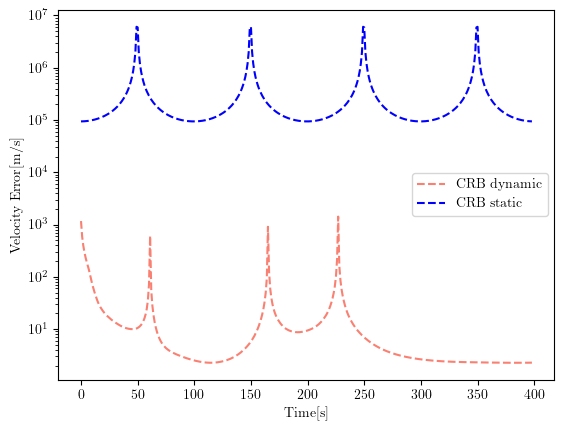

In [642]:

plt.plot(crb_rmse_v_6[1:],c='salmon',linestyle='dashed',label='CRB dynamic')
plt.plot(crb_rmse_v_6s[1:],c='blue',linestyle='dashed',label='CRB static')
plt.yscale('log')
plt.ylabel('Velocity Error[m/s]')
plt.xlabel('Time[s]')
plt.legend()

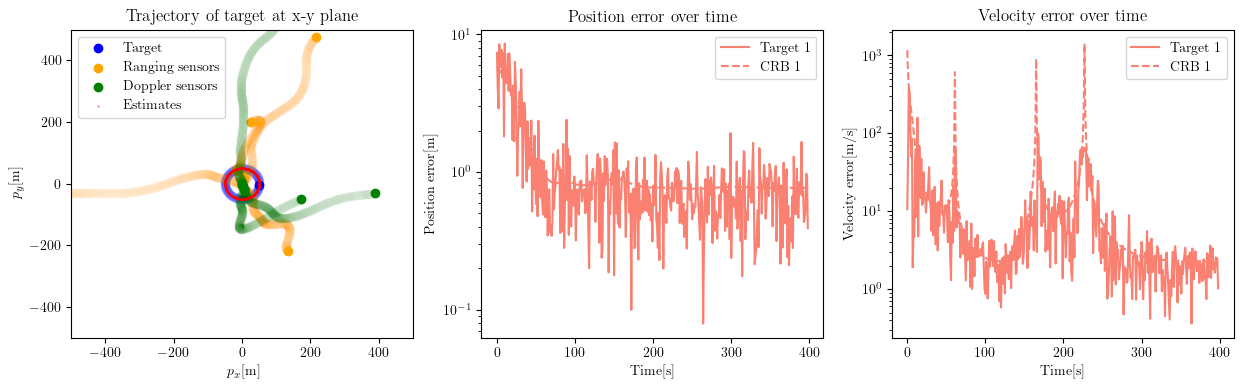

In [638]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(target_6[:,0,:], target_6[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_6[-1,0,:], target_6[-1,1,:],c='blue',alpha=1,label='Target')

plt.scatter(sensors_6[:,0,:n_range_sensors], sensors_6[:,1,:n_range_sensors], alpha=0.02,c='orange')
plt.scatter(sensors_6[-1,0,:n_range_sensors], sensors_6[-1,1,:n_range_sensors], alpha=1,c='orange',label='Ranging sensors')
plt.scatter(sensors_6[:,0,n_range_sensors:], sensors_6[:,1,n_range_sensors:], alpha=0.02,c='green')
plt.scatter(sensors_6[-1,0,n_range_sensors:], sensors_6[-1,1,n_range_sensors:], alpha=1,c='green',label='Doppler sensors')

plt.scatter(est_6[:,0,:], est_6[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')


plt.title('Trajectory of target at x-y plane')
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.xlabel('$p_x$[m]')
plt.ylabel('$p_y$[m]')
plt.legend(loc='best')

plt.subplot(1,3,2)
plt.plot(np.array(cost_6)[1:],c='salmon',label='Target 1')
plt.plot(crb_rmse_p_6[1:],c='salmon',linestyle='dashed',label='CRB 1')
#plt.plot(np.array(cost_6)[1:,1],c='navy',label='Target 2')
#plt.plot(crb_rmse_p_6[1:,1],c='navy',linestyle='dashed',label='CRB 2')
plt.xlabel('Time[s]')
plt.ylabel('Position error[m]')
plt.title('Position error over time')
plt.legend(loc='best')
plt.yscale('log')

plt.subplot(1,3,3)
plt.plot(np.array(velo_6)[1:],c='salmon',label='Target 1')
plt.plot(crb_rmse_v_6[1:],c='salmon',linestyle='dashed',label='CRB 1')
#plt.plot(np.array(cost_6)[1:,1],c='navy',label='Target 2')
#plt.plot(crb_rmse_p_6[1:,1],c='navy',linestyle='dashed',label='CRB 2')
plt.xlabel('Time[s]')
plt.ylabel('Velocity error[m/s]')
plt.title('Velocity error over time')
plt.legend(loc='best')
plt.yscale('log')
#plt.savefig('two-targets-mix.pdf')

In [ ]:
plotgif(400,frames_6,cost_6,[-400,200,-400,200],'zero_doppler',4)

In [ ]:

n_range_sensors = 3
n_doppler_sensors = 3
sensor_helper = EnsembledSensor3DTorchUtils(n_range_sensors)
sensor_simulator = EnsembledSensors3D(n_range_sensors,zeros((6,6)))


previous_est = array([[2 ,-10 ,15 ,0, 0, 0]]).T#

frames_7 = tracking_3D_smooth(K,3,lr_s,lr_t,w2,smooth_3D_trajectory_2,previous_est)
cost_7,sensors_7,target_7,est_7,velo_7,crb_rmse_p_7,crb_rmse_v_7 = extract_costs(frames_7,True)

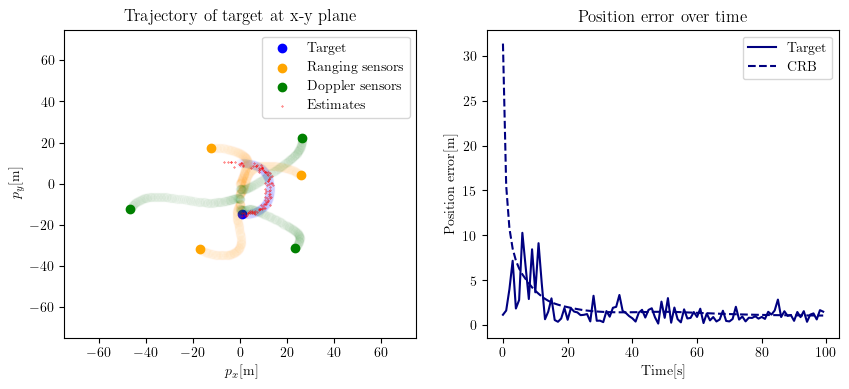

In [61]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(target_7[:,0,:], target_7[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_7[-1,0,:], target_7[-1,1,:],c='blue',alpha=1,label='Target')

plt.scatter(sensors_7[:,0,:n_range_sensors], sensors_7[:,1,:n_range_sensors], alpha=0.02,c='orange')
plt.scatter(sensors_7[-1,0,:n_range_sensors], sensors_7[-1,1,:n_range_sensors], alpha=1,c='orange',label='Ranging sensors')
plt.scatter(sensors_7[:,0,n_range_sensors:], sensors_7[:,1,n_range_sensors:], alpha=0.02,c='green')
plt.scatter(sensors_7[-1,0,n_range_sensors:], sensors_7[-1,1,n_range_sensors:], alpha=1,c='green',label='Doppler sensors')

plt.scatter(est_7[:,0,:], est_7[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')


plt.title('Trajectory of target at x-y plane')
plt.xlim(-75,75)
plt.ylim(-75,75)
plt.xlabel('$p_x$[m]')
plt.ylabel('$p_y$[m]')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(np.array(cost_7)[:,0],c='navy',label='Target')
plt.plot(crb_rmse_p_7[:,0],c='navy',linestyle='dashed',label='CRB')
plt.xlabel('Time[s]')
plt.ylabel('Position error[m]')
plt.title('Position error over time')
plt.legend(loc='best')
plt.savefig('one-target-mix.pdf')

In [221]:

n_range_sensors = 3
n_doppler_sensors = 3

range_u_s = [-0.02,0.02]
range_u_t = [-0.01,0.01]

previous_est = array([[2 ,-10 ,15 ,0, 0, 0]]).T#

M = 20
#_cost_k0 = []
#_velo_k0 = []
#_crb_rmse_p_k0 = []
#_crb_rmse_v_k0 = []

    
for i in range(M):
    print('iter',i)
    try:
        sensor_helper = EnsembledSensor3DTorchUtils(n_range_sensors)
        sensor_simulator = EnsembledSensors3D(n_range_sensors,zeros((6,6)))

        frames_k0 = tracking_3D_smooth(K,3,lr_s,lr_t,w2,smooth_3D_trajectory_2,previous_est,kappa=0)
        cost_k0,sensors_k0,target_k0,est_k0,velo_k0,crb_rmse_p_k0,crb_rmse_v_k0 = extract_costs(frames_k0,True)

        _cost_k0.append(array(cost_k0).flatten())
        _velo_k0.append(velo_k0)
        _crb_rmse_p_k0.append(crb_rmse_p_k0.flatten())
        _crb_rmse_v_k0.append(crb_rmse_v_k0.flatten())
    except:
        print('woops')

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19


In [222]:
import pickle
with open('kappa_0.pk','wb') as f:
    pickle.dump((_cost_k0[:100],_velo_k0[:100],_crb_rmse_p_k0[:100],_crb_rmse_v_k0[:100]),f)



In [223]:
with open('kappa_0.pk','rb') as f:
    _cost_k0,_velo_k0,_crb_rmse_p_k0,_crb_rmse_v_k0 = pickle.load(f)

In [224]:

n_range_sensors = 3
n_doppler_sensors = 3


range_u_s = [-0.02,0.02]
range_u_t = [-0.01,0.01]

previous_est = array([[2 ,-10 ,15 ,0, 0, 0]]).T#

M = 40
#_cost_k0001 = []
#_velo_k0001 = []
#_crb_rmse_p_k0001 = []
#_crb_rmse_v_k0001 = []
for i in range(M):
    print('iter',i)
    try:
        sensor_helper = EnsembledSensor3DTorchUtils(n_range_sensors)
        sensor_simulator = EnsembledSensors3D(n_range_sensors,zeros((6,6)))

        frames_k0001 = tracking_3D_smooth(K,3,lr_s,lr_t,w2,smooth_3D_trajectory_2,previous_est,kappa=0.001)
        cost_k0001,sensors_k0001,target_k0001,est_k0001,velo_k0001,crb_rmse_p_k0001,crb_rmse_v_k0001 = extract_costs(frames_k0001,True)

        _cost_k0001.append(array(cost_k0001).flatten())
        _velo_k0001.append(velo_k0001)
        _crb_rmse_p_k0001.append(crb_rmse_p_k0001.flatten())
        _crb_rmse_v_k0001.append(crb_rmse_v_k0001.flatten())
    except:
        print('woops')

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
woops
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
woops
iter 20
iter 21
iter 22
iter 23
iter 24
woops
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
woops
iter 36
iter 37
iter 38
iter 39


In [236]:

with open('kappa_0001.pk','wb') as f:
    pickle.dump((_cost_k0001[:100],_velo_k0001[:100],_crb_rmse_p_k0001[:100],_crb_rmse_v_k0001[:100]),f)

In [237]:

n_range_sensors = 3
n_doppler_sensors = 3


range_u_s = [-0.02,0.02]
range_u_t = [-0.01,0.01]

previous_est = array([[2 ,-10 ,15 ,0, 0, 0]]).T#

M = 20
#_cost_k001 = []
#_velo_k001 = []
#_crb_rmse_p_k001 = []
#_crb_rmse_v_k001 = []
for i in range(M):
    print('iter',i)
    try:
        sensor_helper = EnsembledSensor3DTorchUtils(n_range_sensors)
        sensor_simulator = EnsembledSensors3D(n_range_sensors,zeros((6,6)))

        frames_k001 = tracking_3D_smooth(K,3,lr_s,lr_t,w2,smooth_3D_trajectory_2,previous_est,kappa=0.01)
        cost_k001,sensors_k001,target_k001,est_k001,velo_k001,crb_rmse_p_k001,crb_rmse_v_k001 = extract_costs(frames_k001,True)

        _cost_k001.append(array(cost_k001).flatten())
        _velo_k001.append(velo_k001)
        _crb_rmse_p_k001.append(crb_rmse_p_k001.flatten())
        _crb_rmse_v_k001.append(crb_rmse_v_k001.flatten())
    except:
        print('woops')

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
woops
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
woops
iter 15
iter 16
iter 17
iter 18
iter 19


In [ ]:

with open('kappa_001.pk','wb') as f:
    pickle.dump((_cost_k001[:100],_velo_k001[:100],_crb_rmse_p_k001[:100],_crb_rmse_v_k001[:100]),f)

In [214]:

n_range_sensors = 3
n_doppler_sensors = 3


range_u_s = [-0.02,0.02]
range_u_t = [-0.01,0.01]

previous_est = array([[2 ,-10 ,15 ,0, 0, 0]]).T#

M = 20
_cost_k01 = []
_velo_k01 = []
_crb_rmse_p_k01 = []
_crb_rmse_v_k01 = []
for i in range(M):
    print('iter',i)
    try:
        sensor_helper = EnsembledSensor3DTorchUtils(n_range_sensors)
        sensor_simulator = EnsembledSensors3D(n_range_sensors,zeros((6,6)))

        frames_k01 = tracking_3D_smooth(K,3,lr_s,lr_t,w2,smooth_3D_trajectory_2,previous_est,kappa=0.1)
        cost_k01,sensors_k01,target_k01,est_k01,velo_k01,crb_rmse_p_k01,crb_rmse_v_k01 = extract_costs(frames_k01,True)

        _cost_k01.append(array(cost_k01).flatten())
        _velo_k01.append(velo_k01)
        _crb_rmse_p_k01.append(crb_rmse_p_k01.flatten())
        _crb_rmse_v_k01.append(crb_rmse_v_k01.flatten())
    except:
        print('woops')

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
woops
iter 8
woops
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
woops
iter 19


In [215]:

n_range_sensors = 3
n_doppler_sensors = 3


range_u_s = [-0.02,0.02]
range_u_t = [-0.01,0.01]

previous_est = array([[2 ,-10 ,15 ,0, 0, 0]]).T#

M = 20
_cost_k1 = []
_velo_k1 = []
_crb_rmse_p_k1 = []
_crb_rmse_v_k1 = []
for i in range(M):
    print('iter',i)
    try:
        sensor_helper = EnsembledSensor3DTorchUtils(n_range_sensors)
        sensor_simulator = EnsembledSensors3D(n_range_sensors,zeros((6,6)))

        frames_k1 = tracking_3D_smooth(K,3,lr_s,lr_t,w2,smooth_3D_trajectory_2,previous_est,kappa=1)
        cost_k1,sensors_k1,target_k1,est_k1,velo_k1,crb_rmse_p_k1,crb_rmse_v_k1 = extract_costs(frames_k1,True)

        _cost_k1.append(array(cost_k1).flatten())
        _velo_k1.append(velo_k1)
        _crb_rmse_p_k1.append(crb_rmse_p_k1.flatten())
        _crb_rmse_v_k1.append(crb_rmse_v_k1.flatten())
    except:
        print('woops')

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
woops
iter 11
iter 12
woops
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19


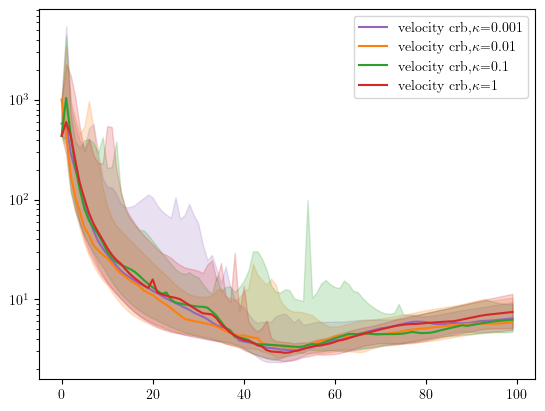

In [229]:

plt.fill_between(range(100),np.quantile(array(_crb_rmse_v_k0),0.1,axis=0), np.quantile(array(_crb_rmse_v_k0),0.9,axis=0),alpha=0.2,color='C0')
plt.plot(np.quantile(array(_crb_rmse_v_k0),0.5,axis=0),color='C0',label='velocity crb,$\kappa$=0')
plt.fill_between(range(100),np.quantile(array(_crb_rmse_v_k0001),0.1,axis=0), np.quantile(array(_crb_rmse_v_k0001),0.9,axis=0),alpha=0.2,color='C4')
plt.plot(np.quantile(array(_crb_rmse_v_k0001),0.5,axis=0),color='C4',label='velocity crb,$\kappa$=0.001')
plt.fill_between(range(100),np.quantile(array(_crb_rmse_v_k001),0.1,axis=0), np.quantile(array(_crb_rmse_v_k001),0.9,axis=0),alpha=0.2,color='C1')
plt.plot(np.quantile(array(_crb_rmse_v_k001),0.5,axis=0),color='C1',label='velocity crb,$\kappa$=0.01')
plt.fill_between(range(100),np.quantile(array(_crb_rmse_v_k01),0.1,axis=0), np.quantile(array(_crb_rmse_v_k01),0.9,axis=0),alpha=0.2,color='C2')
plt.plot(np.quantile(array(_crb_rmse_v_k01),0.5,axis=0),color='C2',label='velocity crb,$\kappa$=0.1')
plt.fill_between(range(100),np.quantile(array(_crb_rmse_v_k1),0.1,axis=0), np.quantile(array(_crb_rmse_v_k1),0.9,axis=0),alpha=0.2,color='C3')
plt.plot(np.quantile(array(_crb_rmse_v_k1),0.5,axis=0),color='C3',label='velocity crb,$\kappa$=1')
plt.yscale('log')
plt.legend()

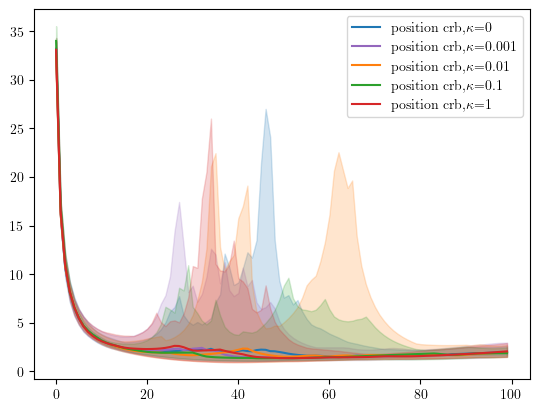

In [233]:

plt.fill_between(range(100),np.quantile(array(_crb_rmse_p_k0),0.1,axis=0), np.quantile(array(_crb_rmse_p_k0),0.9,axis=0),alpha=0.2,color='C0')
plt.plot(np.quantile(array(_crb_rmse_p_k0),0.5,axis=0),color='C0',label='position crb,$\kappa$=0')
plt.fill_between(range(100),np.quantile(array(_crb_rmse_p_k0001),0.1,axis=0), np.quantile(array(_crb_rmse_p_k0001),0.9,axis=0),alpha=0.2,color='C4')
plt.plot(np.quantile(array(_crb_rmse_p_k0001),0.5,axis=0),color='C4',label='position crb,$\kappa$=0.001')
plt.fill_between(range(100),np.quantile(array(_crb_rmse_p_k001),0.1,axis=0), np.quantile(array(_crb_rmse_p_k001),0.9,axis=0),alpha=0.2,color='C1')
plt.plot(np.quantile(array(_crb_rmse_p_k001),0.5,axis=0),color='C1',label='position crb,$\kappa$=0.01')
plt.fill_between(range(100),np.quantile(array(_crb_rmse_p_k01),0.1,axis=0), np.quantile(array(_crb_rmse_p_k01),0.9,axis=0),alpha=0.2,color='C2')
plt.plot(np.quantile(array(_crb_rmse_p_k01),0.5,axis=0),color='C2',label='position crb,$\kappa$=0.1')
plt.fill_between(range(100),np.quantile(array(_crb_rmse_p_k1),0.1,axis=0), np.quantile(array(_crb_rmse_p_k1),0.9,axis=0),alpha=0.2,color='C3')
plt.plot(np.quantile(array(_crb_rmse_p_k1),0.5,axis=0),color='C3',label='position crb,$\kappa$=1')
plt.legend()

Text(0.5, 1.0, 'CRB of position error over time')

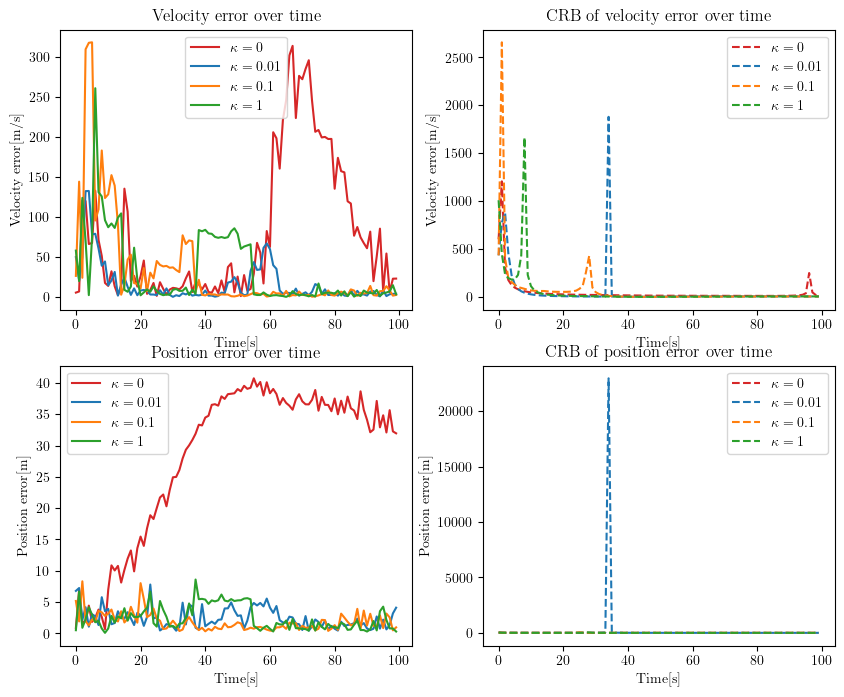

In [169]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(velo_k0,c='C3',label='$\kappa = 0$')
plt.plot(velo_k001,c='C0',label='$\kappa = 0.01$')
plt.plot(velo_k01,c='C1',label='$\kappa = 0.1$')
plt.plot(velo_k1,c='C2',label='$\kappa = 1$')
plt.legend()
plt.xlabel('Time[s]')
plt.ylabel('Velocity error[m/s]')
plt.title('Velocity error over time')


plt.subplot(2,2,2)

plt.plot(crb_rmse_v_k0,c='C3',linestyle='dashed',label='$\kappa = 0$')
plt.plot(crb_rmse_v_k001,c='C0',linestyle='dashed',label='$\kappa = 0.01$')
plt.plot(crb_rmse_v_k01,c='C1',linestyle='dashed',label='$\kappa = 0.1$')
plt.plot(crb_rmse_v_k1,c='C2',linestyle='dashed',label='$\kappa = 1$')
plt.legend()
plt.xlabel('Time[s]')
plt.ylabel('Velocity error[m/s]')
plt.title('CRB of velocity error over time')

plt.subplot(2,2,3)
plt.plot(cost_k0,c='C3',label='$\kappa = 0$')
plt.plot(cost_k001,c='C0',label='$\kappa = 0.01$')
plt.plot(cost_k01,c='C1',label='$\kappa = 0.1$')
plt.plot(cost_k1,c='C2',label='$\kappa = 1$')
plt.legend()
plt.xlabel('Time[s]')
plt.ylabel('Position error[m]')
plt.title('Position error over time')

plt.subplot(2,2,4)
plt.plot(crb_rmse_p_k0,c='C3',linestyle='dashed',label='$\kappa = 0$')
plt.plot(crb_rmse_p_k001,c='C0',linestyle='dashed',label='$\kappa = 0.01$')
plt.plot(crb_rmse_p_k01,c='C1',linestyle='dashed',label='$\kappa = 0.1$')
plt.plot(crb_rmse_p_k1,c='C2',linestyle='dashed',label='$\kappa = 1$')
plt.legend()
#plt.yscale('log')
plt.xlabel('Time[s]')
plt.ylabel('Position error[m]')
plt.title('CRB of position error over time')

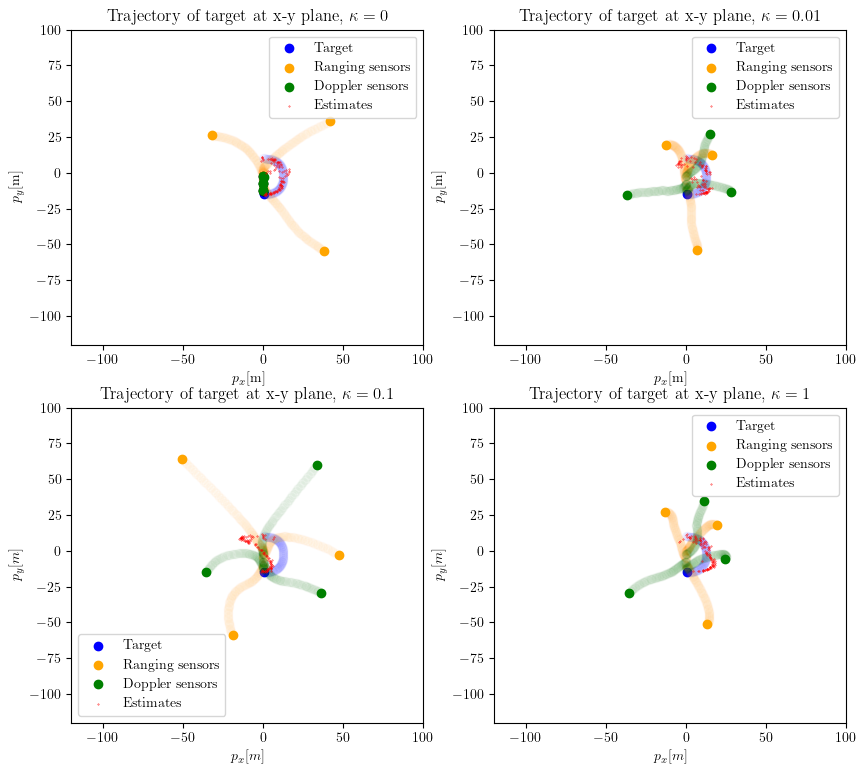

In [231]:
plt.figure(figsize=(10,9))
plt.subplot(2,2,1)
plt.scatter(target_k0[:,0,:], target_k0[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_k0[-1,0,:], target_k0[-1,1,:],c='blue',alpha=1,label='Target')

plt.scatter(sensors_k0[:,0,:n_range_sensors], sensors_k0[:,1,:n_range_sensors], alpha=0.02,c='orange')
plt.scatter(sensors_k0[-1,0,:n_range_sensors], sensors_k0[-1,1,:n_range_sensors], alpha=1,c='orange',label='Ranging sensors')
plt.scatter(sensors_k0[:,0,n_range_sensors:], sensors_k0[:,1,n_range_sensors:], alpha=0.02,c='green')
plt.scatter(sensors_k0[-1,0,n_range_sensors:], sensors_k0[-1,1,n_range_sensors:], alpha=1,c='green',label='Doppler sensors')

plt.scatter(est_k0[:,0,:], est_k0[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')
plt.title('Trajectory of target at x-y plane, $\kappa=0$')
plt.xlim(-120,100)
plt.ylim(-120,100)
plt.xlabel('$p_x$[m]')
plt.ylabel('$p_y$[m]')
plt.legend(loc='best')


plt.subplot(2,2,2)
plt.scatter(target_k001[:,0,:], target_k001[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_k001[-1,0,:], target_k001[-1,1,:],c='blue',alpha=1,label='Target')

plt.scatter(sensors_k001[:,0,:n_range_sensors], sensors_k001[:,1,:n_range_sensors], alpha=0.02,c='orange')
plt.scatter(sensors_k001[-1,0,:n_range_sensors], sensors_k001[-1,1,:n_range_sensors], alpha=1,c='orange',label='Ranging sensors')
plt.scatter(sensors_k001[:,0,n_range_sensors:], sensors_k001[:,1,n_range_sensors:], alpha=0.02,c='green')
plt.scatter(sensors_k001[-1,0,n_range_sensors:], sensors_k001[-1,1,n_range_sensors:], alpha=1,c='green',label='Doppler sensors')

plt.scatter(est_k001[:,0,:], est_k001[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')
plt.title('Trajectory of target at x-y plane, $\kappa=0.01$')
plt.xlim(-120,100)
plt.ylim(-120,100)
plt.xlabel('$p_x$[m]')
plt.ylabel('$p_y$[m]')
plt.legend(loc='best')

plt.subplot(2,2,3)
plt.scatter(target_k01[:,0,:], target_k01[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_k01[-1,0,:], target_k01[-1,1,:],c='blue',alpha=1,label='Target')

plt.scatter(sensors_k01[:,0,:n_range_sensors], sensors_k01[:,1,:n_range_sensors], alpha=0.02,c='orange')
plt.scatter(sensors_k01[-1,0,:n_range_sensors], sensors_k01[-1,1,:n_range_sensors], alpha=1,c='orange',label='Ranging sensors')
plt.scatter(sensors_k01[:,0,n_range_sensors:], sensors_k01[:,1,n_range_sensors:], alpha=0.02,c='green')
plt.scatter(sensors_k01[-1,0,n_range_sensors:], sensors_k01[-1,1,n_range_sensors:], alpha=1,c='green',label='Doppler sensors')

plt.scatter(est_k01[:,0,:], est_k01[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')
plt.title('Trajectory of target at x-y plane, $\kappa=0.1$')
plt.xlim(-120,100)
plt.ylim(-120,100)
plt.xlabel('$p_x[m]$')
plt.ylabel('$p_y[m]$')
plt.legend(loc='best')

plt.subplot(2,2,4)
plt.scatter(target_k1[:,0,:], target_k1[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_k1[-1,0,:], target_k1[-1,1,:],c='blue',alpha=1,label='Target')

plt.scatter(sensors_k1[:,0,:n_range_sensors], sensors_k1[:,1,:n_range_sensors], alpha=0.02,c='orange')
plt.scatter(sensors_k1[-1,0,:n_range_sensors], sensors_k1[-1,1,:n_range_sensors], alpha=1,c='orange',label='Ranging sensors')
plt.scatter(sensors_k1[:,0,n_range_sensors:], sensors_k1[:,1,n_range_sensors:], alpha=0.02,c='green')
plt.scatter(sensors_k1[-1,0,n_range_sensors:], sensors_k1[-1,1,n_range_sensors:], alpha=1,c='green',label='Doppler sensors')

plt.scatter(est_k1[:,0,:], est_k1[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')
plt.title('Trajectory of target at x-y plane, $\kappa=1$')
plt.xlim(-120,100)
plt.ylim(-120,100)
plt.xlabel('$p_x[m]$')
plt.ylabel('$p_y[m]$')
plt.legend(loc='best')

In [ ]:

range_u_s = [-0.02,0.02]
range_u_t = [-0.01,0.01]

n_range_sensors = 4
previous_est = array([[1 ,2 ,15 ,0, 0, 0],[3,2,0,0,0,0]]).T#
sensor_helper = RangeSensor3DTorchUtils()
sensor_simulator = RangingSensors3D(zeros((6,4)))
frames_9 = tracking_3D_smooth(K,3,lr_s,lr_t,w2,smooth_3D_trajectory_5,previous_est)

In [165]:
cost_9,sensors_9,target_9,est_9,crb_rmse_p_9 = extract_costs(frames_9)

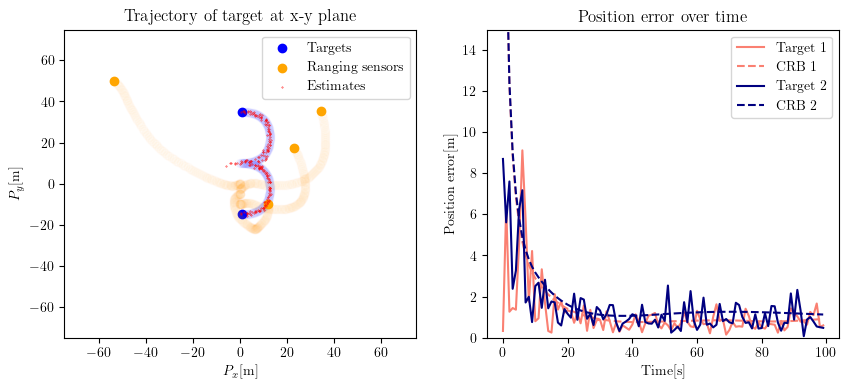

In [168]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(target_9[:,0,:], target_9[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_9[-1,0,:], target_9[-1,1,:],c='blue',alpha=1,label='Targets')

plt.scatter(sensors_9[:,0,:], sensors_9[:,1,:], alpha=0.02,c='orange')
plt.scatter(sensors_9[-1,0,:], sensors_9[-1,1,:], alpha=1,c='orange',label='Ranging sensors')
plt.scatter(est_9[:,0,:], est_9[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')
plt.title('Trajectory of target at x-y plane')
plt.xlim(-75,75)
plt.ylim(-75,75)
plt.xlabel('$P_x$[m]')
plt.ylabel('$P_y$[m]')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(np.array(cost_9)[:,0],c='salmon',label='Target 1')
plt.plot(crb_rmse_p_9[:,0],c='salmon',linestyle='dashed',label='CRB 1')
plt.plot(np.array(cost_9)[:,1],c='navy',label='Target 2')
plt.plot(crb_rmse_p_9[:,1],c='navy',linestyle='dashed',label='CRB 2')
plt.ylim(0,15)
plt.xlabel('Time[s]')
plt.ylabel('Position error[m]')
plt.title('Position error over time')
plt.legend(loc='best')
plt.savefig('two-targets-range.pdf')

In [ ]:

#n_doppler_sensors = 3
#sensor_helper = EnsembledSensor3DTorchUtils(n_range_sensors)
#sensor_simulator = EnsembledSensors3D(n_range_sensors,zeros((6,7)))


n_range_sensors = 4
previous_est = array([[1 ,2 ,15 ,0, 0, 0],[3,2,0,0,0,0]]).T#
sensor_helper = RangeSensor3DTorchUtils()
sensor_simulator = RangingSensors3D(zeros((6,4)))
frames_2 = tracking_3D_smooth(K,3,lr_s,lr_t,w2,smooth_3D_trajectory_5,previous_est)
cost_2,sensors_2,target_2,est_2,velo_2 = extract_costs(frames_2,True)

In [ ]:
n_range_sensors = 4
previous_est = array([[1 ,2 ,15 ,0, 0, 0],[3,2,0,0,0,0]]).T#
sensor_helper = RangeSensor3DTorchUtils()
sensor_simulator = RangingSensors3D(zeros((6,4)))
frames_3 = tracking_3D_smooth(K,3,lr_s,lr_t,w2,smooth_3D_trajectory_5,previous_est,ekf=True)
cost_3,sensors_3,target_3,est_3,velo_3 = extract_costs(frames_3,True)

In [ ]:
mc2 = []
mc3 = []
M = 20

for i in range(M):
    print('i=',str(i))
    try:
        n_range_sensors = 4
        previous_est = array([[1 ,2 ,15 ,0, 0, 0],[3,2,0,0,0,0]]).T#
        sensor_helper = RangeSensor3DTorchUtils()
        sensor_simulator = RangingSensors3D(zeros((6,4)))
        frames_2 = tracking_3D_smooth(K,3,lr_s,lr_t,w2,smooth_3D_trajectory_5,previous_est)
        cost_2,sensors_2,target_2,est_2 = extract_costs(frames_2)
        mc2.append(cost_2)
    except:
        print('?',str(i))
        
    try:   
        n_range_sensors = 4
        previous_est = array([[1 ,2 ,15 ,0, 0, 0],[3,2,0,0,0,0]]).T#
        sensor_helper = RangeSensor3DTorchUtils()
        sensor_simulator = RangingSensors3D(zeros((6,4)))
        frames_3 = tracking_3D_smooth(K,3,lr_s,lr_t,w2,smooth_3D_trajectory_5,previous_est,ekf=True)
        cost_3,sensors_3,target_3,est_3 = extract_costs(frames_3)
        mc3.append(cost_3)
    except:
        print('?',str(i))
    
        

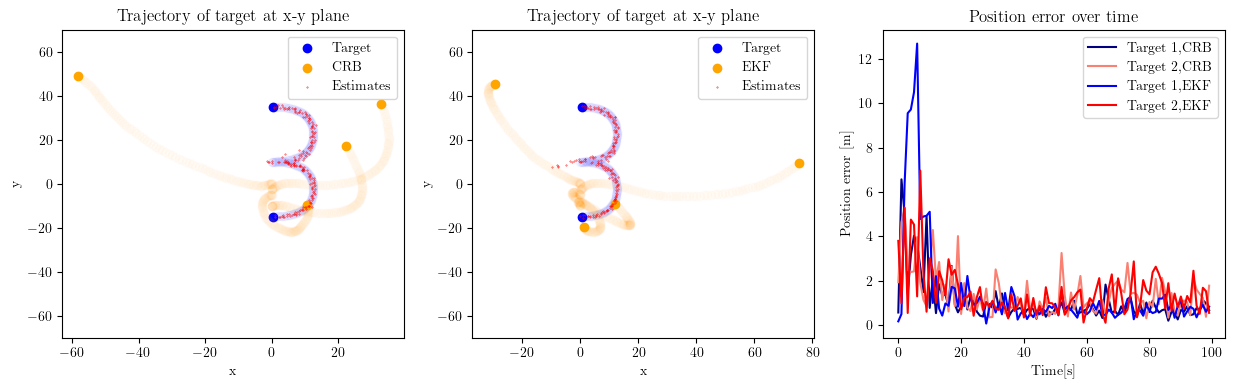

In [640]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(target_2[:,0,:], target_2[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_2[-1,0,:], target_2[-1,1,:],c='blue',alpha=1,label='Target')

plt.scatter(sensors_2[:,0,:], sensors_2[:,1,:], alpha=0.02,c='orange')
plt.scatter(sensors_2[-1,0,:], sensors_2[-1,1,:], alpha=1,c='orange',label='CRB')
plt.scatter(est_2[:,0,:], est_2[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')
plt.title('Trajectory of target at x-y plane')
#plt.xlim(-100,100)
plt.ylim(-70,70)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')

plt.subplot(1,3,2)
plt.scatter(target_3[:,0,:], target_3[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_3[-1,0,:], target_3[-1,1,:],c='blue',alpha=1,label='Target')

plt.scatter(sensors_3[:,0,:], sensors_3[:,1,:], alpha=0.02,c='orange')
plt.scatter(sensors_3[-1,0,:], sensors_3[-1,1,:], alpha=1,c='orange',label='EKF')
plt.scatter(est_3[:,0,:], est_3[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')
plt.title('Trajectory of target at x-y plane')
#plt.xlim(-100,100)
plt.ylim(-70,70)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')

plt.subplot(1,3,3)
plt.plot(array(cost_2)[:,0],c='navy',label='Target 1,CRB')
plt.plot(array(cost_2)[:,1],c='salmon',label='Target 2,CRB')
plt.plot(array(cost_3)[:,0],c='blue',label='Target 1,EKF')
plt.plot(array(cost_3)[:,1],c='red',label='Target 2,EKF')
plt.xlabel('Time[s]')
plt.ylabel('Position error [m]')
plt.title('Position error over time')
plt.legend()

In [ ]:


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(target_2[:,0,:], target_2[:,1,:],c='blue',alpha=0.02)
plt.scatter(target_2[-1,0,:], target_2[-1,1,:],c='blue',alpha=1,label='Target')

#plt.scatter(sensors_2[:,0,:], sensors_2[:,1,:], alpha=0.02,c='orange')
#plt.scatter(sensors_2[-1,0,:], sensors_2[-1,1,:], alpha=1,c='orange',label='Ranging sensors')

plt.scatter(sensors_2[:,0,:n_range_sensors], sensors_2[:,1,:n_range_sensors], alpha=0.02,c='orange')
plt.scatter(sensors_2[-1,0,:n_range_sensors], sensors_2[-1,1,:n_range_sensors], alpha=1,c='orange',label='Ranging sensors')
plt.scatter(sensors_2[:,0,n_range_sensors:], sensors_2[:,1,n_range_sensors:], alpha=0.02,c='green')
plt.scatter(sensors_2[-1,0,n_range_sensors:], sensors_2[-1,1,n_range_sensors:], alpha=1,c='green',label='Doppler sensors')
plt.scatter(est_2[:,0,:], est_2[:,1,:], alpha=1,c='red',s=0.1,label='Estimates')
plt.title('Trajectory of target at x-y plane')
#plt.xlim(-100,100)
plt.ylim(-70,70)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(array(cost_2)[:,0],c='navy',label='Target 1')
plt.plot(array(cost_2)[:,1],c='salmon',label='Target 2')
plt.xlabel('Time[s]')
plt.ylabel('Position error [m]')
plt.title('Position error over time')
plt.legend()

#plt.savefig('two-targets-mix.pdf', bbox_inches='tight')  
#plt.savefig('one-target-mix.pdf', bbox_inches='tight')  

#plt.subplot(1,3,3)
#for i in range(est_2.shape[2]):
#    plt.scatter(range(K),est_2[:,2,i],c='red',s=0.1,label='$\hat{p}_z$')
#    plt.scatter(range(K),target_2[:,2,i],c='blue',alpha=0.02)
#    plt.scatter([K],target_2[-1,2,i],c='blue',label='$p_z$')
#plt.xlabel('Time')
#plt.ylabel('z-axis')
#plt.ylim(0,15)
#plt.title('Tracking trajectory at z-axis')
#plt.legend()
#plt.show()

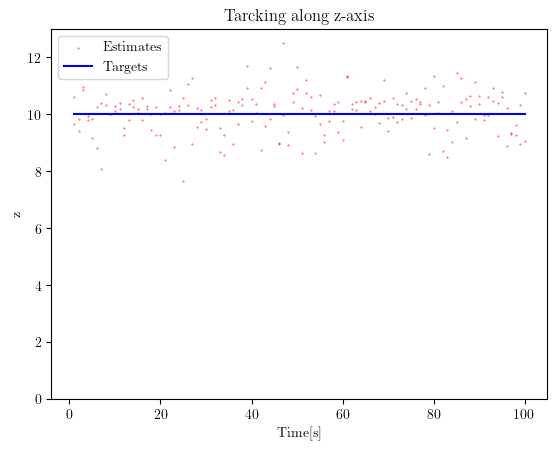

In [379]:
plt.scatter([i+1 for i in range(100)],est_2[:,2,0],s=0.1,c='red',label='Estimates')
plt.scatter([i+1 for i in range(100)],est_2[:,2,1],s=0.1,c='red')
plt.plot([i+1 for i in range(100)],target_2[:,2,0],c='blue',label='Targets')
plt.ylim(0,13)
plt.xlabel('Time[s]')
plt.ylabel('z')
plt.title('Tarcking along z-axis')
plt.legend()
plt.savefig('two-targets-mix-z.pdf', bbox_inches='tight')  
#plt.show()

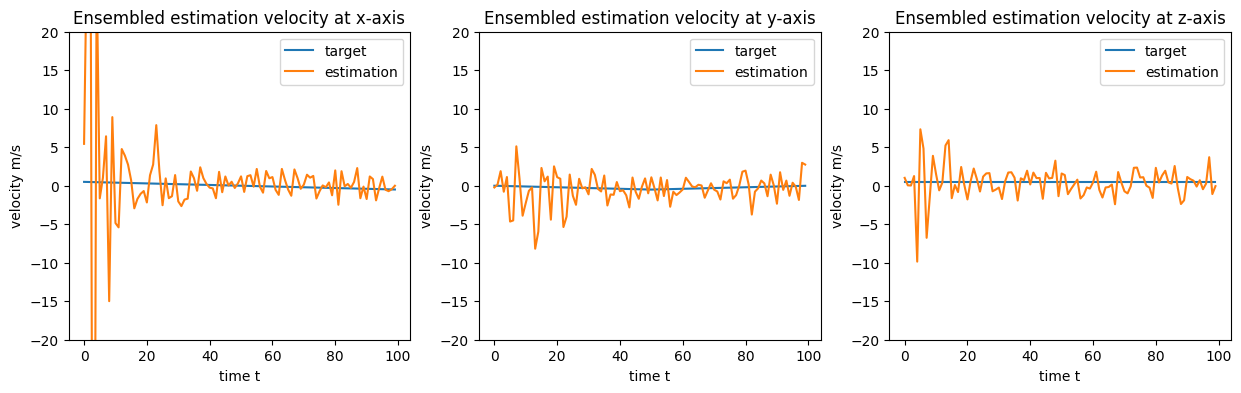

In [52]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(target_2[:,3,:],label='target')
plt.plot(est_2[:,3,:],label='estimation')
plt.title('Ensembled estimation velocity at x-axis')
plt.xlabel('time t')
plt.ylabel('velocity m/s')
plt.ylim(-20,20)
plt.legend()

plt.subplot(1,3,2)
plt.plot(target_2[:,4,:],label='target')
plt.plot(est_2[:,4,:],label='estimation')
plt.title('Ensembled estimation velocity at y-axis')
plt.xlabel('time t')
plt.ylabel('velocity m/s')
plt.ylim(-20,20)
plt.legend()

plt.subplot(1,3,3)
plt.plot(target_2[:,5,:],label='target')
plt.plot(est_2[:,5,:],label='estimation')
plt.title('Ensembled estimation velocity at z-axis')
plt.xlabel('time t')
plt.ylabel('velocity m/s')
plt.ylim(-20,20)
plt.legend()
plt.show()

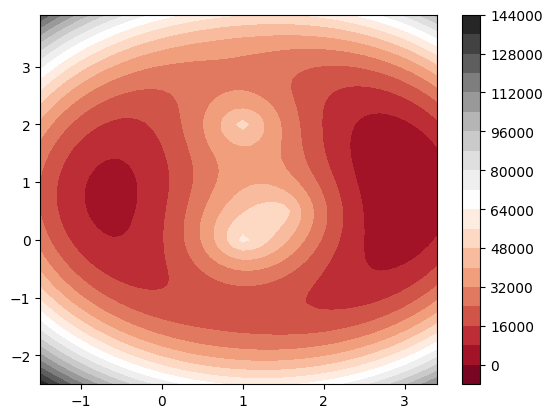

In [4026]:
sensors = np.array([[1,0],[1.5,0.5],[1,2]])
target = np.array([[3,1]])
s2 = 0.0001
alpha=0.05
mu,cov,d_mu,d_cov,inv_cov = stats_2d_range(sensors,target)
obs = simu_2d_range(mu,cov,size=3)

X,Y = np.mgrid[-1.5:3.5:0.1,-2.5:4:0.1]
N,M = X.shape
Z = np.zeros((N,M))
for i in range(N):
    for j in range(M):
        Z[i,j] = negloglikelihood((X[i,j],Y[i,j]),obs[0],lambda x:stats_2d_range(sensors,x))
        
        
plt.contourf(X, Y, Z, 20, cmap='RdGy')
plt.colorbar()
plt.show()

In [736]:
P = np.array([[1,3,2,0],[2,6,4,1]])
np.linalg.matrix_rank(P.T@P)

2